In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
from IPython.display import HTML

from PIL import Image

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


In [2]:
# Root directory for dataset
dataroot = "/home/ubuntu/exp/swivel/data/shapenet/shapenet_images_128_1.5/02691156"

# Number of workers for dataloader
workers = 1

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 4

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Number of training epochs
num_epochs = 500

# Learning rate for optimizers
lr_D = 0.00001
lr_G = 0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
beta2 = 0.999

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

resume = True

checkpoint_file = 'swivel_gan_doublemix_ico3_lr0-00001-nocentroids-nonorm.pth'


def show_images(images):
    images = images[:, :3] 
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(np.transpose(img, (1,2,0)))
#         plt.imshow(img.reshape([image_size, image_size, 3]))
    return 

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset

def pil_alpha_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGBA')
    
    
dataset = dset.ImageFolder(root=dataroot,
            transform=transforms.ToTensor(),
            loader = pil_alpha_loader,
        )
num_data = len(dataset) - len(dataset) % batch_size
print(num_data)
                
# Create the dataloader
prelim_dataloader = torch.utils.data.DataLoader(dataset, batch_size=num_data,
                                         shuffle=True, num_workers=0)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Retrieve all data
total_batch = next(iter(prelim_dataloader))
# plt.figure(figsize=(8,600))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(total_batch[0].to(device)[:num_data], padding=2, normalize=True).cpu(),(1,2,0)))

4032


In [4]:
dataset_tensor = total_batch[0]
print(dataset_tensor.shape)

torch.Size([4032, 4, 128, 128])


In [5]:
from torch.utils.data import TensorDataset

tensor_dataset = TensorDataset(dataset_tensor)
print(len(tensor_dataset))

dataloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=0, pin_memory=True
                                        )



4032


In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
from models import RenderedGenerator, Discriminator

netG = RenderedGenerator(batch_size=batch_size, z_dim=nz, image_size=image_size, random_pose=True).cuda()
netG.apply(weights_init)

netD = Discriminator(image_size=image_size, image_channels=4).cuda()
netD.apply(weights_init)


Discriminator(
  (conv_blocks): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Dropout2d(p=0.25)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Dropout2d(p=0.25)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace)
    (9): Dropout2d(p=0.25)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace)
    (13): Dropout2d(p=0.25)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adv_layer): Sequential(
    (0): Linear(in_features=8192, out_features=1, bias=Tru

In [8]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in netG.state_dict():
    print(param_tensor, "\t", netG.state_dict()[param_tensor].size())

Model's state_dict:
mesh_generator.fc1.weight 	 torch.Size([1024, 100])
mesh_generator.fc1.bias 	 torch.Size([1024])
mesh_generator.bn1.weight 	 torch.Size([1024])
mesh_generator.bn1.bias 	 torch.Size([1024])
mesh_generator.bn1.running_mean 	 torch.Size([1024])
mesh_generator.bn1.running_var 	 torch.Size([1024])
mesh_generator.bn1.num_batches_tracked 	 torch.Size([])
mesh_generator.fc2.weight 	 torch.Size([1024, 1024])
mesh_generator.fc2.bias 	 torch.Size([1024])
mesh_generator.bn2.weight 	 torch.Size([1024])
mesh_generator.bn2.bias 	 torch.Size([1024])
mesh_generator.bn2.running_mean 	 torch.Size([1024])
mesh_generator.bn2.running_var 	 torch.Size([1024])
mesh_generator.bn2.num_batches_tracked 	 torch.Size([])
mesh_generator.fc_bias.weight 	 torch.Size([1926, 1024])
mesh_generator.fc_bias.bias 	 torch.Size([1926])


In [9]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.Tensor(batch_size, nz).normal_(0,1).cuda()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizer_D = optim.Adam(netD.parameters(), lr=lr_D, betas=(beta1, 0.999))
optimizer_G = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, 0.999))

In [10]:
def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.
    Inputs:
    - scores_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    loss = (((scores_real - 1)**2).mean() + (scores_fake**2).mean()) / 2
    return loss

def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.
    Inputs:
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    Outputs:
    - loss: A PyTorch Tensor containing the loss. """
    loss = ((1 - scores_fake)**2).mean() / 2
    return loss

Starting Training Loop...
[Epoch 0/500] [Batch 0/126] [D loss: 0.693143][G loss: 0.693014][Lap loss: 117.439919] D(x): 0.0004 D(G(z)): 0.0004/0.0003


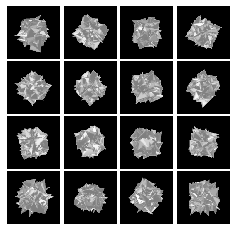

[Epoch 0/500] [Batch 50/126] [D loss: 0.692506][G loss: 0.693735][Lap loss: 68.560364] D(x): 0.0007 D(G(z)): -0.0019/-0.0012
[Epoch 0/500] [Batch 100/126] [D loss: 0.690372][G loss: 0.695674][Lap loss: 50.762138] D(x): 0.0031 D(G(z)): -0.0080/-0.0050
[Epoch 1/500] [Batch 0/126] [D loss: 0.688065][G loss: 0.702285][Lap loss: 45.577339] D(x): 0.0018 D(G(z)): -0.0187/-0.0181
[Epoch 1/500] [Batch 50/126] [D loss: 0.672723][G loss: 0.740626][Lap loss: 39.792221] D(x): -0.0090 D(G(z)): -0.0938/-0.0922
[Epoch 1/500] [Batch 100/126] [D loss: 0.624254][G loss: 0.915449][Lap loss: 35.030319] D(x): -0.0979 D(G(z)): -0.4282/-0.4001
[Epoch 2/500] [Batch 0/126] [D loss: 0.612170][G loss: 1.050735][Lap loss: 32.304268] D(x): -0.1985 D(G(z)): -0.6499/-0.6147
[Epoch 2/500] [Batch 50/126] [D loss: 0.586139][G loss: 1.285565][Lap loss: 28.327751] D(x): -0.2457 D(G(z)): -0.9200/-0.9518
[Epoch 2/500] [Batch 100/126] [D loss: 0.586281][G loss: 1.309410][Lap loss: 24.561392] D(x): -0.2631 D(G(z)): -0.9776/-0

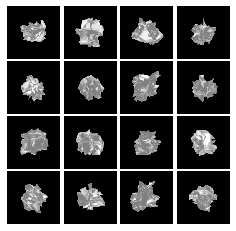

[Epoch 4/500] [Batch 0/126] [D loss: 0.438930][G loss: 1.679991][Lap loss: 18.386431] D(x): 0.1847 D(G(z)): -1.3529/-1.4583
[Epoch 4/500] [Batch 50/126] [D loss: 0.356168][G loss: 1.881668][Lap loss: 16.618666] D(x): 0.5082 D(G(z)): -1.5082/-1.7010
[Epoch 4/500] [Batch 100/126] [D loss: 0.359610][G loss: 1.806989][Lap loss: 16.115433] D(x): 0.5695 D(G(z)): -1.5477/-1.5975
[Epoch 5/500] [Batch 0/126] [D loss: 0.270093][G loss: 1.913099][Lap loss: 15.155738] D(x): 1.0078 D(G(z)): -1.8058/-1.7154
[Epoch 5/500] [Batch 50/126] [D loss: 0.241762][G loss: 2.290677][Lap loss: 15.403972] D(x): 1.2647 D(G(z)): -2.0288/-2.1211
[Epoch 5/500] [Batch 100/126] [D loss: 0.227226][G loss: 2.376450][Lap loss: 14.019389] D(x): 1.5204 D(G(z)): -2.1863/-2.2023
[Epoch 6/500] [Batch 0/126] [D loss: 0.241272][G loss: 2.225070][Lap loss: 14.163542] D(x): 1.6384 D(G(z)): -2.2864/-2.0429
[Epoch 6/500] [Batch 50/126] [D loss: 0.243772][G loss: 2.617611][Lap loss: 14.167562] D(x): 1.6420 D(G(z)): -2.2406/-2.4755
[

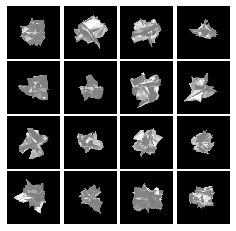

[Epoch 8/500] [Batch 0/126] [D loss: 0.151860][G loss: 3.176544][Lap loss: 13.168666] D(x): 2.6856 D(G(z)): -3.1501/-3.0294
[Epoch 8/500] [Batch 50/126] [D loss: 0.145233][G loss: 2.859944][Lap loss: 12.733334] D(x): 2.5989 D(G(z)): -3.0738/-2.6969
[Epoch 8/500] [Batch 100/126] [D loss: 0.128212][G loss: 2.712168][Lap loss: 13.025315] D(x): 3.0062 D(G(z)): -2.5632/-2.5651
[Epoch 9/500] [Batch 0/126] [D loss: 0.181457][G loss: 2.904664][Lap loss: 13.214788] D(x): 2.6417 D(G(z)): -2.5967/-2.7518
[Epoch 9/500] [Batch 50/126] [D loss: 0.256470][G loss: 3.189550][Lap loss: 12.227497] D(x): 1.7242 D(G(z)): -3.1483/-3.0466
[Epoch 9/500] [Batch 100/126] [D loss: 0.135109][G loss: 3.255191][Lap loss: 11.897989] D(x): 2.6639 D(G(z)): -3.4211/-3.1553
[Epoch 10/500] [Batch 0/126] [D loss: 0.175671][G loss: 3.284642][Lap loss: 11.584032] D(x): 2.3236 D(G(z)): -2.8938/-3.1710
[Epoch 10/500] [Batch 50/126] [D loss: 0.162945][G loss: 2.787067][Lap loss: 11.337032] D(x): 2.8231 D(G(z)): -2.6951/-2.5625

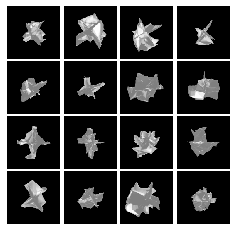

[Epoch 12/500] [Batch 0/126] [D loss: 0.248130][G loss: 3.033392][Lap loss: 12.151952] D(x): 1.9729 D(G(z)): -3.2149/-2.8580
[Epoch 12/500] [Batch 50/126] [D loss: 0.209656][G loss: 3.369287][Lap loss: 11.662672] D(x): 2.1942 D(G(z)): -3.0607/-3.2353
[Epoch 12/500] [Batch 100/126] [D loss: 0.132177][G loss: 3.263759][Lap loss: 11.559891] D(x): 3.3806 D(G(z)): -2.5819/-3.1893
[Epoch 13/500] [Batch 0/126] [D loss: 0.128556][G loss: 3.329931][Lap loss: 11.269677] D(x): 3.0140 D(G(z)): -3.4843/-3.2247
[Epoch 13/500] [Batch 50/126] [D loss: 0.095267][G loss: 4.244004][Lap loss: 14.471643] D(x): 2.8559 D(G(z)): -4.4225/-4.2055
[Epoch 13/500] [Batch 100/126] [D loss: 0.155338][G loss: 3.462533][Lap loss: 12.810761] D(x): 2.1335 D(G(z)): -3.2827/-3.3778
[Epoch 14/500] [Batch 0/126] [D loss: 0.146190][G loss: 3.441421][Lap loss: 12.385787] D(x): 2.9848 D(G(z)): -3.6740/-3.3529
[Epoch 14/500] [Batch 50/126] [D loss: 0.101616][G loss: 3.630104][Lap loss: 12.406880] D(x): 3.2313 D(G(z)): -3.4330/-

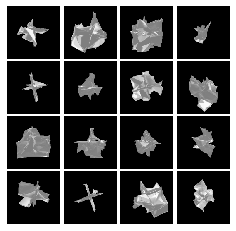

[Epoch 16/500] [Batch 0/126] [D loss: 0.098469][G loss: 3.589955][Lap loss: 11.451660] D(x): 3.0906 D(G(z)): -3.8084/-3.4711
[Epoch 16/500] [Batch 50/126] [D loss: 0.224569][G loss: 3.767261][Lap loss: 11.890209] D(x): 1.5803 D(G(z)): -3.7215/-3.6358
[Epoch 16/500] [Batch 100/126] [D loss: 0.073457][G loss: 3.804468][Lap loss: 12.316633] D(x): 3.5828 D(G(z)): -3.5934/-3.6996
[Epoch 17/500] [Batch 0/126] [D loss: 0.091088][G loss: 3.650057][Lap loss: 11.005895] D(x): 2.7776 D(G(z)): -3.5816/-3.5923
[Epoch 17/500] [Batch 50/126] [D loss: 0.246182][G loss: 3.107483][Lap loss: 11.861630] D(x): 2.1836 D(G(z)): -3.2786/-2.9522
[Epoch 17/500] [Batch 100/126] [D loss: 0.137774][G loss: 3.487944][Lap loss: 12.103994] D(x): 2.7412 D(G(z)): -3.6961/-3.4146
[Epoch 18/500] [Batch 0/126] [D loss: 0.144929][G loss: 3.311915][Lap loss: 11.591753] D(x): 3.5291 D(G(z)): -3.0331/-3.1231
[Epoch 18/500] [Batch 50/126] [D loss: 0.142058][G loss: 3.230948][Lap loss: 11.713726] D(x): 3.1572 D(G(z)): -3.1643/-

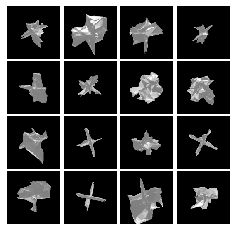

[Epoch 20/500] [Batch 0/126] [D loss: 0.172841][G loss: 3.126940][Lap loss: 11.961000] D(x): 2.5019 D(G(z)): -2.9516/-3.0163
[Epoch 20/500] [Batch 50/126] [D loss: 0.108889][G loss: 2.944692][Lap loss: 11.332475] D(x): 2.8577 D(G(z)): -3.3354/-2.7706
[Epoch 20/500] [Batch 100/126] [D loss: 0.160538][G loss: 3.507237][Lap loss: 11.425742] D(x): 2.7606 D(G(z)): -3.4043/-3.4079
[Epoch 21/500] [Batch 0/126] [D loss: 0.132455][G loss: 3.649044][Lap loss: 10.761940] D(x): 3.6504 D(G(z)): -3.3161/-3.4616
[Epoch 21/500] [Batch 50/126] [D loss: 0.192734][G loss: 2.356695][Lap loss: 10.832327] D(x): 3.6835 D(G(z)): -2.0454/-2.0350
[Epoch 21/500] [Batch 100/126] [D loss: 0.127508][G loss: 3.231246][Lap loss: 11.364457] D(x): 3.2355 D(G(z)): -2.8132/-3.1386
[Epoch 22/500] [Batch 0/126] [D loss: 0.152974][G loss: 3.116694][Lap loss: 11.548338] D(x): 2.6647 D(G(z)): -2.6454/-2.9965
[Epoch 22/500] [Batch 50/126] [D loss: 0.089825][G loss: 3.355939][Lap loss: 11.161139] D(x): 4.4567 D(G(z)): -2.8883/-

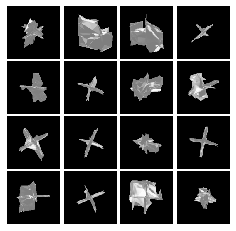

[Epoch 24/500] [Batch 0/126] [D loss: 0.098295][G loss: 2.720248][Lap loss: 10.779930] D(x): 4.9046 D(G(z)): -2.7624/-2.5411
[Epoch 24/500] [Batch 50/126] [D loss: 0.213401][G loss: 2.053598][Lap loss: 10.224185] D(x): 2.1476 D(G(z)): -2.3206/-1.7501
[Epoch 24/500] [Batch 100/126] [D loss: 0.170103][G loss: 3.264672][Lap loss: 10.346385] D(x): 3.0170 D(G(z)): -2.8270/-3.1757
[Epoch 25/500] [Batch 0/126] [D loss: 0.192884][G loss: 2.425709][Lap loss: 10.639648] D(x): 2.9779 D(G(z)): -2.3135/-2.1671
[Epoch 25/500] [Batch 50/126] [D loss: 0.127117][G loss: 2.740407][Lap loss: 11.331915] D(x): 3.1597 D(G(z)): -2.3998/-2.4321
[Epoch 25/500] [Batch 100/126] [D loss: 0.195896][G loss: 3.366987][Lap loss: 10.165312] D(x): 2.6963 D(G(z)): -2.6165/-3.1717
[Epoch 26/500] [Batch 0/126] [D loss: 0.270691][G loss: 1.942269][Lap loss: 10.463442] D(x): 2.5557 D(G(z)): -1.6166/-1.5617
[Epoch 26/500] [Batch 50/126] [D loss: 0.164709][G loss: 3.174406][Lap loss: 10.568627] D(x): 2.0890 D(G(z)): -3.1913/-

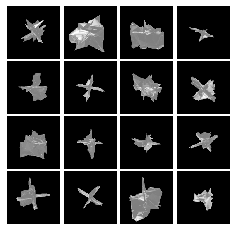

[Epoch 27/500] [Batch 100/126] [D loss: 0.380930][G loss: 1.953186][Lap loss: 10.838786] D(x): 1.1546 D(G(z)): -2.2561/-1.6985
[Epoch 28/500] [Batch 0/126] [D loss: 0.223100][G loss: 2.545394][Lap loss: 9.922196] D(x): 3.0096 D(G(z)): -2.0562/-2.3556
[Epoch 28/500] [Batch 50/126] [D loss: 0.307130][G loss: 2.146773][Lap loss: 9.588312] D(x): 1.7477 D(G(z)): -1.9864/-1.8854
[Epoch 28/500] [Batch 100/126] [D loss: 0.133336][G loss: 2.597409][Lap loss: 9.491841] D(x): 3.0186 D(G(z)): -2.5278/-2.3998
[Epoch 29/500] [Batch 0/126] [D loss: 0.352548][G loss: 2.493900][Lap loss: 9.195994] D(x): 0.6743 D(G(z)): -2.6456/-2.2633
[Epoch 29/500] [Batch 50/126] [D loss: 0.333482][G loss: 2.026783][Lap loss: 9.295568] D(x): 1.5348 D(G(z)): -1.4837/-1.7122
[Epoch 29/500] [Batch 100/126] [D loss: 0.402073][G loss: 2.405993][Lap loss: 9.425655] D(x): 1.1780 D(G(z)): -2.0173/-2.1840
[Epoch 30/500] [Batch 0/126] [D loss: 0.146976][G loss: 1.959091][Lap loss: 8.718493] D(x): 3.1316 D(G(z)): -2.2470/-1.6720

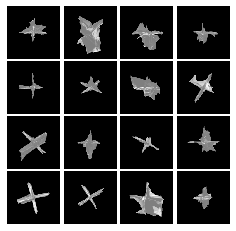

[Epoch 31/500] [Batch 100/126] [D loss: 0.274916][G loss: 1.773064][Lap loss: 7.798467] D(x): 1.8543 D(G(z)): -1.7548/-1.4330
[Epoch 32/500] [Batch 0/126] [D loss: 0.551157][G loss: 1.938541][Lap loss: 8.213503] D(x): 0.1394 D(G(z)): -1.4966/-1.6832
[Epoch 32/500] [Batch 50/126] [D loss: 0.350481][G loss: 1.398372][Lap loss: 8.900506] D(x): 0.9444 D(G(z)): -1.7329/-0.9408
[Epoch 32/500] [Batch 100/126] [D loss: 0.749704][G loss: 1.144496][Lap loss: 7.759169] D(x): 1.0224 D(G(z)): 0.0509/-0.4676
[Epoch 33/500] [Batch 0/126] [D loss: 0.679675][G loss: 1.122643][Lap loss: 7.952014] D(x): 0.2438 D(G(z)): -0.7133/-0.4583
[Epoch 33/500] [Batch 50/126] [D loss: 0.338812][G loss: 1.360203][Lap loss: 8.379396] D(x): 2.0577 D(G(z)): -1.0893/-0.8721
[Epoch 33/500] [Batch 100/126] [D loss: 0.441844][G loss: 1.278895][Lap loss: 8.242903] D(x): 2.0786 D(G(z)): -0.4245/-0.7232
[Epoch 34/500] [Batch 0/126] [D loss: 0.819726][G loss: 2.097105][Lap loss: 8.309916] D(x): -0.7210 D(G(z)): -1.3786/-1.8401


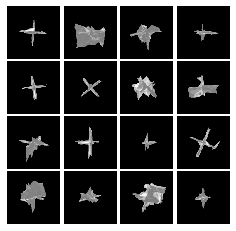

[Epoch 35/500] [Batch 100/126] [D loss: 0.473728][G loss: 1.366580][Lap loss: 7.058848] D(x): 1.3251 D(G(z)): -0.4477/-0.9619
[Epoch 36/500] [Batch 0/126] [D loss: 0.733310][G loss: 0.972487][Lap loss: 7.375676] D(x): 1.0788 D(G(z)): 0.3626/-0.3296
[Epoch 36/500] [Batch 50/126] [D loss: 0.882951][G loss: 0.585452][Lap loss: 6.331071] D(x): -0.0795 D(G(z)): -0.3718/0.6650
[Epoch 36/500] [Batch 100/126] [D loss: 0.634501][G loss: 0.859016][Lap loss: 6.988921] D(x): 0.9437 D(G(z)): -0.0733/-0.0305
[Epoch 37/500] [Batch 0/126] [D loss: 0.642181][G loss: 1.006784][Lap loss: 6.975826] D(x): 0.5268 D(G(z)): -0.3232/-0.4186
[Epoch 37/500] [Batch 50/126] [D loss: 0.675918][G loss: 1.249180][Lap loss: 6.620087] D(x): 0.1199 D(G(z)): -0.5925/-0.7647
[Epoch 37/500] [Batch 100/126] [D loss: 0.819114][G loss: 1.167834][Lap loss: 6.902512] D(x): -0.4144 D(G(z)): -0.5100/-0.6662
[Epoch 38/500] [Batch 0/126] [D loss: 0.950381][G loss: 0.764659][Lap loss: 6.423911] D(x): -0.1801 D(G(z)): 0.2369/0.0364
[

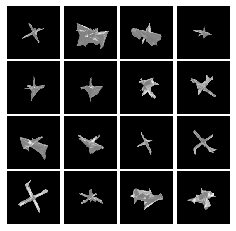

[Epoch 39/500] [Batch 100/126] [D loss: 0.654464][G loss: 0.807554][Lap loss: 6.506970] D(x): 0.6660 D(G(z)): -0.0226/-0.1024
[Epoch 40/500] [Batch 0/126] [D loss: 0.746102][G loss: 0.679351][Lap loss: 6.178091] D(x): 0.2992 D(G(z)): 0.0240/0.2436
[Epoch 40/500] [Batch 50/126] [D loss: 0.665664][G loss: 0.869675][Lap loss: 6.170100] D(x): 0.5007 D(G(z)): -0.0727/-0.1595
[Epoch 40/500] [Batch 100/126] [D loss: 0.587100][G loss: 0.978963][Lap loss: 6.228214] D(x): 0.6958 D(G(z)): -0.2546/-0.3604
[Epoch 41/500] [Batch 0/126] [D loss: 0.664848][G loss: 1.019997][Lap loss: 5.912658] D(x): 0.5261 D(G(z)): -0.1897/-0.4101
[Epoch 41/500] [Batch 50/126] [D loss: 0.879642][G loss: 0.868629][Lap loss: 6.025828] D(x): -0.3866 D(G(z)): -0.1026/-0.1871
[Epoch 41/500] [Batch 100/126] [D loss: 0.674037][G loss: 0.992205][Lap loss: 5.762189] D(x): 0.1492 D(G(z)): -0.3682/-0.4219
[Epoch 42/500] [Batch 0/126] [D loss: 0.602667][G loss: 0.971605][Lap loss: 5.963249] D(x): 0.2009 D(G(z)): -0.5586/-0.4023
[

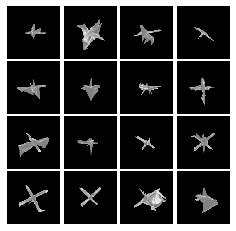

[Epoch 43/500] [Batch 100/126] [D loss: 0.538945][G loss: 0.899794][Lap loss: 6.100270] D(x): 0.6438 D(G(z)): -0.4633/-0.2291
[Epoch 44/500] [Batch 0/126] [D loss: 0.614027][G loss: 0.956586][Lap loss: 6.027995] D(x): 0.5177 D(G(z)): -0.2988/-0.3010
[Epoch 44/500] [Batch 50/126] [D loss: 0.633988][G loss: 0.950402][Lap loss: 5.868815] D(x): 0.3786 D(G(z)): -0.2363/-0.3496
[Epoch 44/500] [Batch 100/126] [D loss: 0.541373][G loss: 1.020833][Lap loss: 6.618693] D(x): 0.5886 D(G(z)): -0.3649/-0.5160
[Epoch 45/500] [Batch 0/126] [D loss: 0.629673][G loss: 1.136377][Lap loss: 6.361268] D(x): 0.2880 D(G(z)): -0.5102/-0.6842
[Epoch 45/500] [Batch 50/126] [D loss: 0.634552][G loss: 1.032931][Lap loss: 6.103960] D(x): 0.7196 D(G(z)): 0.0657/-0.4547
[Epoch 45/500] [Batch 100/126] [D loss: 0.636780][G loss: 0.842709][Lap loss: 6.096652] D(x): 0.4325 D(G(z)): -0.0785/-0.2041
[Epoch 46/500] [Batch 0/126] [D loss: 0.568948][G loss: 1.078211][Lap loss: 6.816597] D(x): 0.5935 D(G(z)): -0.3423/-0.6007
[

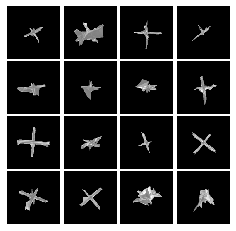

[Epoch 47/500] [Batch 100/126] [D loss: 0.595527][G loss: 0.931070][Lap loss: 6.232718] D(x): 0.6371 D(G(z)): -0.1467/-0.2898
[Epoch 48/500] [Batch 0/126] [D loss: 0.589076][G loss: 1.045631][Lap loss: 5.559147] D(x): 0.6074 D(G(z)): -0.2893/-0.5146
[Epoch 48/500] [Batch 50/126] [D loss: 0.684411][G loss: 1.042707][Lap loss: 6.493652] D(x): 0.3272 D(G(z)): -0.1194/-0.4510
[Epoch 48/500] [Batch 100/126] [D loss: 0.552497][G loss: 0.959241][Lap loss: 5.901410] D(x): 0.7354 D(G(z)): -0.2560/-0.3503
[Epoch 49/500] [Batch 0/126] [D loss: 0.597930][G loss: 1.012009][Lap loss: 5.966942] D(x): 0.4800 D(G(z)): -0.3200/-0.4858
[Epoch 49/500] [Batch 50/126] [D loss: 0.625877][G loss: 0.906840][Lap loss: 6.395146] D(x): 0.6854 D(G(z)): -0.0031/-0.2727
[Epoch 49/500] [Batch 100/126] [D loss: 0.541717][G loss: 0.787540][Lap loss: 5.891578] D(x): 0.6972 D(G(z)): -0.4328/-0.0187
[Epoch 50/500] [Batch 0/126] [D loss: 0.548777][G loss: 1.011275][Lap loss: 5.847318] D(x): 0.9605 D(G(z)): -0.2350/-0.4598


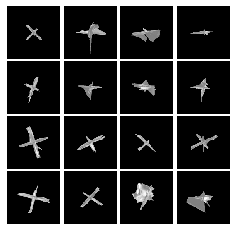

[Epoch 51/500] [Batch 100/126] [D loss: 0.500744][G loss: 1.008925][Lap loss: 6.860032] D(x): 0.9388 D(G(z)): -0.3809/-0.3968
[Epoch 52/500] [Batch 0/126] [D loss: 0.545537][G loss: 0.870594][Lap loss: 6.418923] D(x): 0.6723 D(G(z)): -0.3927/-0.2276
[Epoch 52/500] [Batch 50/126] [D loss: 0.555373][G loss: 0.941702][Lap loss: 6.203832] D(x): 0.6713 D(G(z)): -0.3882/-0.2523
[Epoch 52/500] [Batch 100/126] [D loss: 0.446622][G loss: 1.330038][Lap loss: 6.276553] D(x): 1.0682 D(G(z)): -0.7288/-0.8567
[Epoch 53/500] [Batch 0/126] [D loss: 0.512643][G loss: 1.271170][Lap loss: 6.348362] D(x): 0.7382 D(G(z)): -0.6337/-0.7801
[Epoch 53/500] [Batch 50/126] [D loss: 0.471816][G loss: 1.117229][Lap loss: 5.828432] D(x): 1.1062 D(G(z)): -0.6560/-0.5456
[Epoch 53/500] [Batch 100/126] [D loss: 0.438275][G loss: 1.043676][Lap loss: 5.961410] D(x): 1.5552 D(G(z)): -0.6217/-0.4919
[Epoch 54/500] [Batch 0/126] [D loss: 0.440003][G loss: 1.070974][Lap loss: 5.959577] D(x): 1.1837 D(G(z)): -0.5918/-0.4939


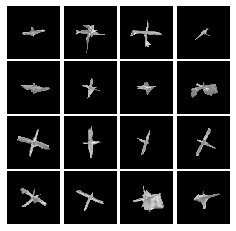

[Epoch 55/500] [Batch 100/126] [D loss: 0.450751][G loss: 1.128285][Lap loss: 5.228761] D(x): 1.1023 D(G(z)): -0.6744/-0.6429
[Epoch 56/500] [Batch 0/126] [D loss: 0.523142][G loss: 1.008394][Lap loss: 5.104371] D(x): 1.2696 D(G(z)): -0.3361/-0.3289
[Epoch 56/500] [Batch 50/126] [D loss: 0.560342][G loss: 1.062288][Lap loss: 4.847015] D(x): 0.6756 D(G(z)): -0.6365/-0.5345
[Epoch 56/500] [Batch 100/126] [D loss: 0.499690][G loss: 1.251945][Lap loss: 5.396716] D(x): 0.5781 D(G(z)): -0.7867/-0.8443
[Epoch 57/500] [Batch 0/126] [D loss: 0.487807][G loss: 1.117845][Lap loss: 4.907244] D(x): 1.5955 D(G(z)): -0.4858/-0.4780
[Epoch 57/500] [Batch 50/126] [D loss: 0.409287][G loss: 1.190398][Lap loss: 5.071440] D(x): 1.7199 D(G(z)): -0.6788/-0.6549
[Epoch 57/500] [Batch 100/126] [D loss: 0.607547][G loss: 1.046523][Lap loss: 4.955260] D(x): 0.5490 D(G(z)): -0.5686/-0.4348
[Epoch 58/500] [Batch 0/126] [D loss: 0.385140][G loss: 1.206998][Lap loss: 5.087408] D(x): 1.6151 D(G(z)): -0.6998/-0.7093


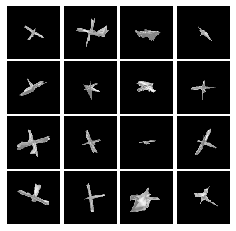

[Epoch 59/500] [Batch 100/126] [D loss: 0.538543][G loss: 1.215880][Lap loss: 5.458955] D(x): 1.0881 D(G(z)): -0.6160/-0.5986
[Epoch 60/500] [Batch 0/126] [D loss: 0.435318][G loss: 1.302132][Lap loss: 4.908962] D(x): 1.1889 D(G(z)): -0.9126/-0.8282
[Epoch 60/500] [Batch 50/126] [D loss: 0.415638][G loss: 1.176109][Lap loss: 4.978138] D(x): 1.4394 D(G(z)): -0.9267/-0.6474
[Epoch 60/500] [Batch 100/126] [D loss: 0.410394][G loss: 1.383423][Lap loss: 5.117537] D(x): 0.9946 D(G(z)): -1.1946/-0.9837
[Epoch 61/500] [Batch 0/126] [D loss: 0.379196][G loss: 1.272050][Lap loss: 4.982782] D(x): 1.6886 D(G(z)): -0.7937/-0.7880
[Epoch 61/500] [Batch 50/126] [D loss: 0.381398][G loss: 1.539988][Lap loss: 5.282114] D(x): 1.4482 D(G(z)): -1.0397/-1.1648
[Epoch 61/500] [Batch 100/126] [D loss: 0.401418][G loss: 1.546512][Lap loss: 5.082048] D(x): 1.4185 D(G(z)): -1.2680/-1.2334
[Epoch 62/500] [Batch 0/126] [D loss: 0.425641][G loss: 1.422017][Lap loss: 4.891426] D(x): 1.4250 D(G(z)): -0.9946/-1.0153


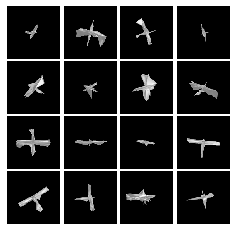

[Epoch 63/500] [Batch 100/126] [D loss: 0.345625][G loss: 1.256154][Lap loss: 4.592226] D(x): 2.0076 D(G(z)): -0.9290/-0.7817
[Epoch 64/500] [Batch 0/126] [D loss: 0.409459][G loss: 1.363245][Lap loss: 4.458506] D(x): 1.7434 D(G(z)): -0.6972/-0.8899
[Epoch 64/500] [Batch 50/126] [D loss: 0.340221][G loss: 1.422709][Lap loss: 5.092206] D(x): 1.8483 D(G(z)): -1.0694/-0.9726
[Epoch 64/500] [Batch 100/126] [D loss: 0.369712][G loss: 1.570668][Lap loss: 5.183904] D(x): 1.5851 D(G(z)): -1.0377/-1.2498
[Epoch 65/500] [Batch 0/126] [D loss: 0.559898][G loss: 1.424801][Lap loss: 5.362109] D(x): 0.7340 D(G(z)): -0.8077/-0.7635
[Epoch 65/500] [Batch 50/126] [D loss: 0.558598][G loss: 1.276265][Lap loss: 5.206336] D(x): 1.0251 D(G(z)): -0.6970/-0.6549
[Epoch 65/500] [Batch 100/126] [D loss: 0.408882][G loss: 1.507063][Lap loss: 5.046709] D(x): 1.5256 D(G(z)): -0.8971/-1.1218
[Epoch 66/500] [Batch 0/126] [D loss: 0.360117][G loss: 1.319647][Lap loss: 4.809639] D(x): 1.6313 D(G(z)): -0.8961/-0.9132


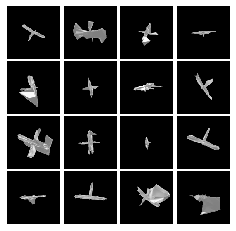

[Epoch 67/500] [Batch 100/126] [D loss: 0.444348][G loss: 1.347543][Lap loss: 4.762697] D(x): 1.5367 D(G(z)): -0.7305/-0.8021
[Epoch 68/500] [Batch 0/126] [D loss: 0.337008][G loss: 1.298721][Lap loss: 4.609742] D(x): 2.0938 D(G(z)): -0.8304/-0.8018
[Epoch 68/500] [Batch 50/126] [D loss: 0.437406][G loss: 1.601693][Lap loss: 4.768235] D(x): 0.8405 D(G(z)): -1.3265/-1.2182
[Epoch 68/500] [Batch 100/126] [D loss: 0.317288][G loss: 1.800448][Lap loss: 4.874790] D(x): 1.6058 D(G(z)): -1.4228/-1.5184
[Epoch 69/500] [Batch 0/126] [D loss: 0.458358][G loss: 1.529693][Lap loss: 5.012267] D(x): 1.2759 D(G(z)): -1.0695/-1.0652
[Epoch 69/500] [Batch 50/126] [D loss: 0.421234][G loss: 1.329524][Lap loss: 4.934256] D(x): 1.1208 D(G(z)): -1.0748/-0.7641
[Epoch 69/500] [Batch 100/126] [D loss: 0.407717][G loss: 1.713582][Lap loss: 4.468938] D(x): 1.3171 D(G(z)): -1.3554/-1.3997
[Epoch 70/500] [Batch 0/126] [D loss: 0.424241][G loss: 1.345352][Lap loss: 4.785579] D(x): 0.9770 D(G(z)): -1.0974/-0.9279


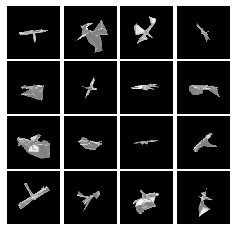

[Epoch 71/500] [Batch 100/126] [D loss: 0.519512][G loss: 1.371547][Lap loss: 4.689859] D(x): 1.2884 D(G(z)): -0.5749/-0.8112
[Epoch 72/500] [Batch 0/126] [D loss: 0.419208][G loss: 1.590872][Lap loss: 4.794711] D(x): 1.0849 D(G(z)): -1.2230/-1.2570
[Epoch 72/500] [Batch 50/126] [D loss: 0.391463][G loss: 1.586802][Lap loss: 4.927098] D(x): 1.2291 D(G(z)): -1.2785/-1.2716
[Epoch 72/500] [Batch 100/126] [D loss: 0.421635][G loss: 1.437863][Lap loss: 4.711753] D(x): 1.6075 D(G(z)): -0.8533/-0.9835
[Epoch 73/500] [Batch 0/126] [D loss: 0.422123][G loss: 1.537294][Lap loss: 4.840093] D(x): 0.9120 D(G(z)): -1.4638/-1.1466
[Epoch 73/500] [Batch 50/126] [D loss: 0.419222][G loss: 1.142192][Lap loss: 4.469980] D(x): 1.6542 D(G(z)): -0.5069/-0.6115
[Epoch 73/500] [Batch 100/126] [D loss: 0.362628][G loss: 1.824761][Lap loss: 4.480801] D(x): 1.1596 D(G(z)): -1.6688/-1.5539
[Epoch 74/500] [Batch 0/126] [D loss: 0.428231][G loss: 1.711334][Lap loss: 4.438626] D(x): 1.0417 D(G(z)): -1.3748/-1.4036


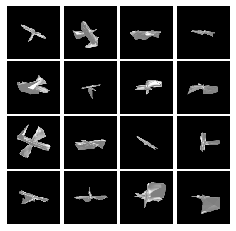

[Epoch 75/500] [Batch 100/126] [D loss: 0.467435][G loss: 1.465851][Lap loss: 4.019086] D(x): 0.9058 D(G(z)): -0.9684/-1.0148
[Epoch 76/500] [Batch 0/126] [D loss: 0.307038][G loss: 1.786319][Lap loss: 3.934780] D(x): 1.4078 D(G(z)): -1.7764/-1.5218
[Epoch 76/500] [Batch 50/126] [D loss: 0.427934][G loss: 1.022120][Lap loss: 4.092185] D(x): 1.8130 D(G(z)): -0.4798/-0.2942
[Epoch 76/500] [Batch 100/126] [D loss: 0.394345][G loss: 1.424348][Lap loss: 3.900878] D(x): 1.6476 D(G(z)): -0.9975/-1.0083
[Epoch 77/500] [Batch 0/126] [D loss: 0.435185][G loss: 1.315545][Lap loss: 4.467080] D(x): 1.3727 D(G(z)): -0.6122/-0.8459
[Epoch 77/500] [Batch 50/126] [D loss: 0.477573][G loss: 1.460372][Lap loss: 4.175417] D(x): 0.4472 D(G(z)): -1.1776/-0.9992
[Epoch 77/500] [Batch 100/126] [D loss: 0.452630][G loss: 1.257782][Lap loss: 4.368024] D(x): 0.9969 D(G(z)): -1.0766/-0.7693
[Epoch 78/500] [Batch 0/126] [D loss: 0.457475][G loss: 1.425318][Lap loss: 4.795454] D(x): 0.8736 D(G(z)): -1.1501/-1.0480


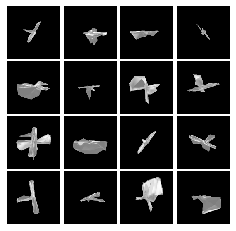

[Epoch 79/500] [Batch 50/126] [D loss: 0.378089][G loss: 1.725577][Lap loss: 4.096009] D(x): 1.3783 D(G(z)): -1.1137/-1.3825
[Epoch 79/500] [Batch 100/126] [D loss: 0.349696][G loss: 1.737810][Lap loss: 4.284167] D(x): 1.0411 D(G(z)): -1.6008/-1.3085
[Epoch 80/500] [Batch 0/126] [D loss: 0.299993][G loss: 1.713238][Lap loss: 4.498495] D(x): 1.9829 D(G(z)): -1.4586/-1.4018
[Epoch 80/500] [Batch 50/126] [D loss: 0.344084][G loss: 1.673086][Lap loss: 4.228118] D(x): 1.0184 D(G(z)): -1.9631/-1.3499
[Epoch 80/500] [Batch 100/126] [D loss: 0.408186][G loss: 1.800103][Lap loss: 4.278407] D(x): 0.7125 D(G(z)): -1.6761/-1.4391
[Epoch 81/500] [Batch 0/126] [D loss: 0.399198][G loss: 1.525520][Lap loss: 4.154196] D(x): 1.1945 D(G(z)): -1.1113/-1.1005
[Epoch 81/500] [Batch 50/126] [D loss: 0.414379][G loss: 1.439861][Lap loss: 4.033987] D(x): 1.3341 D(G(z)): -1.1603/-0.9191
[Epoch 81/500] [Batch 100/126] [D loss: 0.428572][G loss: 1.300572][Lap loss: 4.368753] D(x): 1.4706 D(G(z)): -0.7706/-0.7406

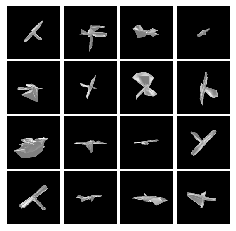

[Epoch 83/500] [Batch 50/126] [D loss: 0.463301][G loss: 1.397454][Lap loss: 3.757751] D(x): 1.1872 D(G(z)): -1.0696/-0.9382
[Epoch 83/500] [Batch 100/126] [D loss: 0.332237][G loss: 2.055253][Lap loss: 4.077370] D(x): 1.2843 D(G(z)): -1.6020/-1.8350
[Epoch 84/500] [Batch 0/126] [D loss: 0.449655][G loss: 1.421503][Lap loss: 4.118664] D(x): 0.8827 D(G(z)): -1.0886/-1.0369
[Epoch 84/500] [Batch 50/126] [D loss: 0.342852][G loss: 1.749362][Lap loss: 4.064371] D(x): 1.7535 D(G(z)): -1.2465/-1.3984
[Epoch 84/500] [Batch 100/126] [D loss: 0.471379][G loss: 1.952425][Lap loss: 3.969575] D(x): 0.5681 D(G(z)): -1.4744/-1.7034
[Epoch 85/500] [Batch 0/126] [D loss: 0.332708][G loss: 1.459876][Lap loss: 3.931028] D(x): 1.7600 D(G(z)): -1.0926/-1.0356
[Epoch 85/500] [Batch 50/126] [D loss: 0.499983][G loss: 1.430160][Lap loss: 3.674863] D(x): 0.6109 D(G(z)): -1.2113/-0.9994
[Epoch 85/500] [Batch 100/126] [D loss: 0.484792][G loss: 1.220047][Lap loss: 3.675919] D(x): 0.8345 D(G(z)): -0.9096/-0.6396

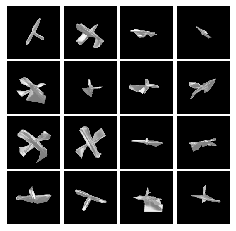

[Epoch 87/500] [Batch 50/126] [D loss: 0.609149][G loss: 1.526616][Lap loss: 3.547932] D(x): 1.0431 D(G(z)): -0.7498/-0.8663
[Epoch 87/500] [Batch 100/126] [D loss: 0.477541][G loss: 0.909322][Lap loss: 3.506935] D(x): 1.4500 D(G(z)): -0.6133/-0.1071
[Epoch 88/500] [Batch 0/126] [D loss: 0.475214][G loss: 1.509679][Lap loss: 3.429237] D(x): 1.0981 D(G(z)): -1.0265/-1.0966
[Epoch 88/500] [Batch 50/126] [D loss: 0.300209][G loss: 1.890324][Lap loss: 3.373758] D(x): 1.2486 D(G(z)): -1.9931/-1.6148
[Epoch 88/500] [Batch 100/126] [D loss: 0.419173][G loss: 1.456608][Lap loss: 3.611366] D(x): 1.0869 D(G(z)): -1.0665/-1.0242
[Epoch 89/500] [Batch 0/126] [D loss: 0.333922][G loss: 2.112893][Lap loss: 3.486131] D(x): 1.3417 D(G(z)): -1.7689/-1.8743
[Epoch 89/500] [Batch 50/126] [D loss: 0.414685][G loss: 1.153285][Lap loss: 3.463726] D(x): 1.1716 D(G(z)): -0.9443/-0.5673
[Epoch 89/500] [Batch 100/126] [D loss: 0.395509][G loss: 1.079134][Lap loss: 3.529069] D(x): 1.4318 D(G(z)): -0.9815/-0.4801

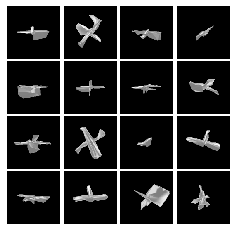

[Epoch 91/500] [Batch 50/126] [D loss: 0.327137][G loss: 2.099903][Lap loss: 3.609883] D(x): 1.1544 D(G(z)): -2.0272/-1.8664
[Epoch 91/500] [Batch 100/126] [D loss: 0.567438][G loss: 1.049042][Lap loss: 4.017879] D(x): 1.6040 D(G(z)): 0.0263/-0.4063
[Epoch 92/500] [Batch 0/126] [D loss: 0.526227][G loss: 1.145285][Lap loss: 3.729032] D(x): 0.9107 D(G(z)): -0.5477/-0.4407
[Epoch 92/500] [Batch 50/126] [D loss: 0.573659][G loss: 1.811882][Lap loss: 3.756053] D(x): 0.1767 D(G(z)): -1.1506/-1.4867
[Epoch 92/500] [Batch 100/126] [D loss: 0.325174][G loss: 1.570236][Lap loss: 3.521601] D(x): 1.4604 D(G(z)): -1.5201/-1.1881
[Epoch 93/500] [Batch 0/126] [D loss: 0.594233][G loss: 1.093377][Lap loss: 3.502764] D(x): 0.6847 D(G(z)): -0.6201/-0.5127
[Epoch 93/500] [Batch 50/126] [D loss: 0.363790][G loss: 1.312881][Lap loss: 3.588184] D(x): 1.2599 D(G(z)): -1.0376/-0.8406
[Epoch 93/500] [Batch 100/126] [D loss: 0.517738][G loss: 1.294610][Lap loss: 3.994933] D(x): 0.5601 D(G(z)): -1.0308/-0.8317


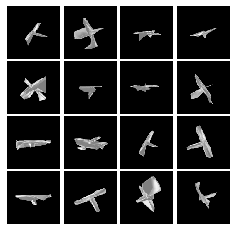

[Epoch 95/500] [Batch 50/126] [D loss: 0.452121][G loss: 1.441614][Lap loss: 3.852046] D(x): 1.0485 D(G(z)): -0.7234/-1.0023
[Epoch 95/500] [Batch 100/126] [D loss: 0.599458][G loss: 1.209446][Lap loss: 3.702989] D(x): 0.4895 D(G(z)): -0.6159/-0.7419
[Epoch 96/500] [Batch 0/126] [D loss: 0.410032][G loss: 1.334896][Lap loss: 3.814942] D(x): 1.0401 D(G(z)): -1.1126/-0.8872
[Epoch 96/500] [Batch 50/126] [D loss: 0.600421][G loss: 1.030144][Lap loss: 3.754399] D(x): 1.1430 D(G(z)): -0.0706/-0.4104
[Epoch 96/500] [Batch 100/126] [D loss: 0.445042][G loss: 1.560003][Lap loss: 3.745935] D(x): 0.7108 D(G(z)): -1.2296/-1.2316
[Epoch 97/500] [Batch 0/126] [D loss: 0.435851][G loss: 1.520617][Lap loss: 3.711301] D(x): 0.9941 D(G(z)): -1.2218/-1.1244
[Epoch 97/500] [Batch 50/126] [D loss: 0.409410][G loss: 1.118483][Lap loss: 3.990199] D(x): 1.5169 D(G(z)): -0.5314/-0.5426
[Epoch 97/500] [Batch 100/126] [D loss: 0.640143][G loss: 0.956616][Lap loss: 4.001752] D(x): 0.7968 D(G(z)): -0.1854/-0.2317

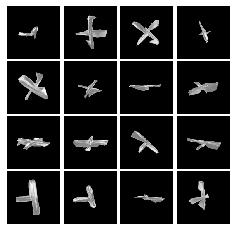

[Epoch 99/500] [Batch 50/126] [D loss: 0.498081][G loss: 1.243490][Lap loss: 3.443120] D(x): 0.9985 D(G(z)): -0.4414/-0.7744
[Epoch 99/500] [Batch 100/126] [D loss: 0.330109][G loss: 1.539611][Lap loss: 3.562271] D(x): 1.4456 D(G(z)): -1.2494/-1.2109
[Epoch 100/500] [Batch 0/126] [D loss: 0.487689][G loss: 1.691998][Lap loss: 3.640359] D(x): 0.5381 D(G(z)): -1.2746/-1.3368
[Epoch 100/500] [Batch 50/126] [D loss: 0.479504][G loss: 1.419251][Lap loss: 3.423718] D(x): 0.9252 D(G(z)): -0.8510/-1.0089
[Epoch 100/500] [Batch 100/126] [D loss: 0.516129][G loss: 1.202977][Lap loss: 3.347331] D(x): 0.8891 D(G(z)): -0.4455/-0.7141
[Epoch 101/500] [Batch 0/126] [D loss: 0.482895][G loss: 1.454594][Lap loss: 3.445024] D(x): 0.5124 D(G(z)): -1.0575/-1.0882
[Epoch 101/500] [Batch 50/126] [D loss: 0.565592][G loss: 1.342690][Lap loss: 3.240382] D(x): 0.5934 D(G(z)): -0.6781/-0.9069
[Epoch 101/500] [Batch 100/126] [D loss: 0.363321][G loss: 1.477777][Lap loss: 3.406200] D(x): 1.4902 D(G(z)): -1.2022/-

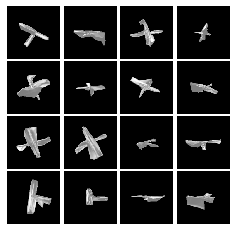

[Epoch 103/500] [Batch 50/126] [D loss: 0.423388][G loss: 1.163150][Lap loss: 3.491651] D(x): 1.3908 D(G(z)): -0.7136/-0.6596
[Epoch 103/500] [Batch 100/126] [D loss: 0.400694][G loss: 1.424736][Lap loss: 3.676006] D(x): 1.0513 D(G(z)): -0.9924/-0.9983
[Epoch 104/500] [Batch 0/126] [D loss: 0.589316][G loss: 0.980364][Lap loss: 3.840397] D(x): 0.8218 D(G(z)): -0.3047/-0.3822
[Epoch 104/500] [Batch 50/126] [D loss: 0.558970][G loss: 1.089420][Lap loss: 3.461448] D(x): 0.5122 D(G(z)): -0.7624/-0.5486
[Epoch 104/500] [Batch 100/126] [D loss: 0.703436][G loss: 1.239892][Lap loss: 3.302602] D(x): 0.1106 D(G(z)): -0.4663/-0.7352
[Epoch 105/500] [Batch 0/126] [D loss: 0.512424][G loss: 1.335580][Lap loss: 3.951913] D(x): 0.2365 D(G(z)): -1.2869/-0.9238
[Epoch 105/500] [Batch 50/126] [D loss: 0.540693][G loss: 1.168527][Lap loss: 3.387755] D(x): 0.5583 D(G(z)): -0.6457/-0.7265
[Epoch 105/500] [Batch 100/126] [D loss: 0.564732][G loss: 0.959645][Lap loss: 3.409410] D(x): 0.8171 D(G(z)): -0.3611

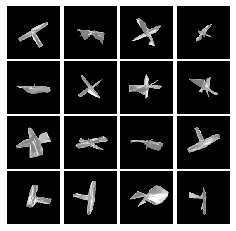

[Epoch 107/500] [Batch 50/126] [D loss: 0.595947][G loss: 1.580759][Lap loss: 3.276542] D(x): 0.1125 D(G(z)): -1.0706/-1.2220
[Epoch 107/500] [Batch 100/126] [D loss: 0.403926][G loss: 1.381318][Lap loss: 3.482084] D(x): 0.9193 D(G(z)): -1.2051/-1.0110
[Epoch 108/500] [Batch 0/126] [D loss: 0.550780][G loss: 1.007238][Lap loss: 3.469459] D(x): 0.7317 D(G(z)): -0.5250/-0.4756
[Epoch 108/500] [Batch 50/126] [D loss: 0.600496][G loss: 1.347684][Lap loss: 3.325035] D(x): 0.1019 D(G(z)): -0.8316/-0.9566
[Epoch 108/500] [Batch 100/126] [D loss: 0.568137][G loss: 1.102560][Lap loss: 3.465523] D(x): 0.5660 D(G(z)): -0.6208/-0.4842
[Epoch 109/500] [Batch 0/126] [D loss: 0.547257][G loss: 0.911006][Lap loss: 3.358122] D(x): 1.1091 D(G(z)): -0.2300/-0.2710
[Epoch 109/500] [Batch 50/126] [D loss: 0.464759][G loss: 1.092321][Lap loss: 3.276115] D(x): 0.9437 D(G(z)): -0.7332/-0.5165
[Epoch 109/500] [Batch 100/126] [D loss: 0.299966][G loss: 1.612972][Lap loss: 3.065568] D(x): 1.4780 D(G(z)): -1.4508

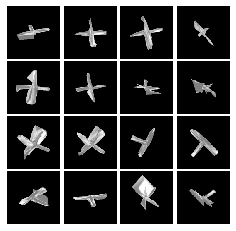

[Epoch 111/500] [Batch 50/126] [D loss: 0.601966][G loss: 1.611251][Lap loss: 3.597039] D(x): 0.0181 D(G(z)): -0.9989/-1.3025
[Epoch 111/500] [Batch 100/126] [D loss: 0.495475][G loss: 1.171540][Lap loss: 3.361587] D(x): 0.8990 D(G(z)): -0.6679/-0.6123
[Epoch 112/500] [Batch 0/126] [D loss: 0.581331][G loss: 1.254578][Lap loss: 3.250164] D(x): 0.3358 D(G(z)): -0.5236/-0.7746
[Epoch 112/500] [Batch 50/126] [D loss: 0.599250][G loss: 1.126921][Lap loss: 3.334922] D(x): 0.4493 D(G(z)): -0.6298/-0.5877
[Epoch 112/500] [Batch 100/126] [D loss: 0.502800][G loss: 1.381166][Lap loss: 3.495725] D(x): 0.8441 D(G(z)): -0.7545/-0.9797
[Epoch 113/500] [Batch 0/126] [D loss: 0.313215][G loss: 1.258409][Lap loss: 3.335271] D(x): 1.3760 D(G(z)): -1.1862/-0.8261
[Epoch 113/500] [Batch 50/126] [D loss: 0.422114][G loss: 1.334248][Lap loss: 3.294636] D(x): 0.8897 D(G(z)): -1.1565/-0.9385
[Epoch 113/500] [Batch 100/126] [D loss: 0.597648][G loss: 1.199794][Lap loss: 3.264480] D(x): 0.1587 D(G(z)): -0.9913

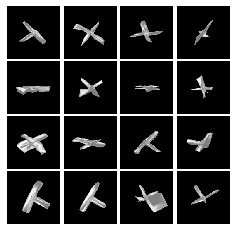

[Epoch 115/500] [Batch 50/126] [D loss: 0.497078][G loss: 1.399874][Lap loss: 3.644073] D(x): 0.8804 D(G(z)): -0.8670/-1.0007
[Epoch 115/500] [Batch 100/126] [D loss: 0.684651][G loss: 1.206340][Lap loss: 3.193091] D(x): -0.0638 D(G(z)): -0.5189/-0.7795
[Epoch 116/500] [Batch 0/126] [D loss: 0.540114][G loss: 0.912425][Lap loss: 3.038868] D(x): 0.8440 D(G(z)): -0.4392/-0.2221
[Epoch 116/500] [Batch 50/126] [D loss: 0.416473][G loss: 1.612327][Lap loss: 3.078766] D(x): 1.1807 D(G(z)): -0.8547/-1.2506
[Epoch 116/500] [Batch 100/126] [D loss: 0.599299][G loss: 1.155808][Lap loss: 2.930317] D(x): 0.4515 D(G(z)): -0.5619/-0.6670
[Epoch 117/500] [Batch 0/126] [D loss: 0.359855][G loss: 1.091469][Lap loss: 2.983550] D(x): 1.2992 D(G(z)): -1.0072/-0.5575
[Epoch 117/500] [Batch 50/126] [D loss: 0.647722][G loss: 1.460960][Lap loss: 3.165139] D(x): 0.1613 D(G(z)): -0.7581/-1.1070
[Epoch 117/500] [Batch 100/126] [D loss: 0.528710][G loss: 1.406093][Lap loss: 3.148590] D(x): 0.4776 D(G(z)): -0.895

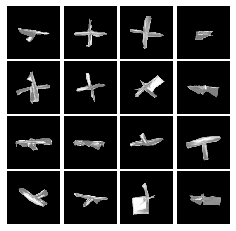

[Epoch 119/500] [Batch 50/126] [D loss: 0.484877][G loss: 1.140187][Lap loss: 2.976509] D(x): 1.1272 D(G(z)): -0.4721/-0.6338
[Epoch 119/500] [Batch 100/126] [D loss: 0.543631][G loss: 1.168175][Lap loss: 2.926169] D(x): 0.5429 D(G(z)): -0.7340/-0.7102
[Epoch 120/500] [Batch 0/126] [D loss: 0.512760][G loss: 1.167461][Lap loss: 2.838960] D(x): 0.6015 D(G(z)): -0.6486/-0.6701
[Epoch 120/500] [Batch 50/126] [D loss: 0.478006][G loss: 1.626331][Lap loss: 2.969770] D(x): 0.6677 D(G(z)): -0.8431/-1.3192
[Epoch 120/500] [Batch 100/126] [D loss: 0.356616][G loss: 1.690525][Lap loss: 3.113702] D(x): 1.1253 D(G(z)): -1.1953/-1.3981
[Epoch 121/500] [Batch 0/126] [D loss: 0.428631][G loss: 1.320492][Lap loss: 3.122273] D(x): 0.8051 D(G(z)): -1.1842/-0.9039
[Epoch 121/500] [Batch 50/126] [D loss: 0.843133][G loss: 0.986673][Lap loss: 3.608593] D(x): 0.2021 D(G(z)): 0.1708/-0.3561
[Epoch 121/500] [Batch 100/126] [D loss: 0.535026][G loss: 1.094395][Lap loss: 3.376816] D(x): 0.6298 D(G(z)): -0.4288/

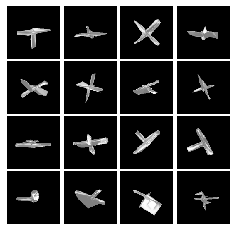

[Epoch 123/500] [Batch 50/126] [D loss: 0.604732][G loss: 1.039974][Lap loss: 3.448558] D(x): 0.1854 D(G(z)): -0.7985/-0.4956
[Epoch 123/500] [Batch 100/126] [D loss: 0.396259][G loss: 1.325266][Lap loss: 3.271283] D(x): 1.4198 D(G(z)): -0.7272/-0.8829
[Epoch 124/500] [Batch 0/126] [D loss: 0.396982][G loss: 0.988543][Lap loss: 3.565170] D(x): 1.3254 D(G(z)): -0.7920/-0.3655
[Epoch 124/500] [Batch 50/126] [D loss: 0.484453][G loss: 1.071305][Lap loss: 3.098178] D(x): 0.9094 D(G(z)): -0.4929/-0.5563
[Epoch 124/500] [Batch 100/126] [D loss: 0.610793][G loss: 1.090803][Lap loss: 3.345577] D(x): 0.1216 D(G(z)): -0.7393/-0.5272
[Epoch 125/500] [Batch 0/126] [D loss: 0.540134][G loss: 0.935424][Lap loss: 3.281359] D(x): 0.5868 D(G(z)): -0.3758/-0.3311
[Epoch 125/500] [Batch 50/126] [D loss: 0.581168][G loss: 1.532092][Lap loss: 3.131942] D(x): 0.3851 D(G(z)): -0.8390/-1.2270
[Epoch 125/500] [Batch 100/126] [D loss: 0.580780][G loss: 0.745406][Lap loss: 2.987021] D(x): 0.9798 D(G(z)): -0.0523

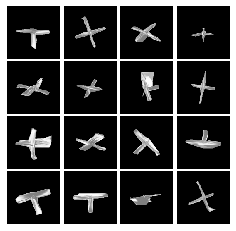

[Epoch 127/500] [Batch 0/126] [D loss: 0.503620][G loss: 0.834538][Lap loss: 2.847294] D(x): 0.6057 D(G(z)): -0.7181/-0.1627
[Epoch 127/500] [Batch 50/126] [D loss: 0.459853][G loss: 1.443397][Lap loss: 2.734532] D(x): 0.9788 D(G(z)): -0.8594/-1.1210
[Epoch 127/500] [Batch 100/126] [D loss: 0.591994][G loss: 0.757475][Lap loss: 2.725745] D(x): 0.9745 D(G(z)): 0.0697/-0.0170
[Epoch 128/500] [Batch 0/126] [D loss: 0.439002][G loss: 0.876832][Lap loss: 3.008344] D(x): 1.3991 D(G(z)): -0.4592/-0.2377
[Epoch 128/500] [Batch 50/126] [D loss: 0.435677][G loss: 1.267243][Lap loss: 3.007472] D(x): 1.0429 D(G(z)): -0.6394/-0.7975
[Epoch 128/500] [Batch 100/126] [D loss: 0.491345][G loss: 0.963998][Lap loss: 3.128503] D(x): 1.1435 D(G(z)): -0.3060/-0.4004
[Epoch 129/500] [Batch 0/126] [D loss: 0.480464][G loss: 0.968867][Lap loss: 2.990182] D(x): 1.3202 D(G(z)): -0.4864/-0.3725
[Epoch 129/500] [Batch 50/126] [D loss: 0.456824][G loss: 1.293915][Lap loss: 2.878815] D(x): 1.0813 D(G(z)): -0.7004/-0

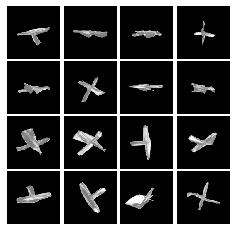

[Epoch 131/500] [Batch 0/126] [D loss: 0.680815][G loss: 1.348267][Lap loss: 3.006307] D(x): -0.0470 D(G(z)): -0.6734/-0.8658
[Epoch 131/500] [Batch 50/126] [D loss: 0.579111][G loss: 1.328841][Lap loss: 3.103167] D(x): 0.3789 D(G(z)): -0.8629/-0.9628
[Epoch 131/500] [Batch 100/126] [D loss: 0.425488][G loss: 1.055966][Lap loss: 2.971039] D(x): 1.2457 D(G(z)): -0.4813/-0.4686
[Epoch 132/500] [Batch 0/126] [D loss: 0.563690][G loss: 1.018824][Lap loss: 3.058785] D(x): 0.8743 D(G(z)): -0.2167/-0.4695
[Epoch 132/500] [Batch 50/126] [D loss: 0.520124][G loss: 1.400364][Lap loss: 3.024717] D(x): 0.3085 D(G(z)): -1.1808/-1.0593
[Epoch 132/500] [Batch 100/126] [D loss: 0.308676][G loss: 1.349900][Lap loss: 2.844564] D(x): 1.5765 D(G(z)): -1.1982/-0.9508
[Epoch 133/500] [Batch 0/126] [D loss: 0.496706][G loss: 1.160041][Lap loss: 2.763826] D(x): 0.8730 D(G(z)): -0.6947/-0.6798
[Epoch 133/500] [Batch 50/126] [D loss: 0.454168][G loss: 0.991227][Lap loss: 2.791276] D(x): 1.0730 D(G(z)): -0.6037/

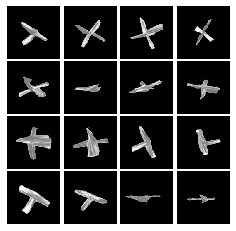

[Epoch 135/500] [Batch 0/126] [D loss: 0.606890][G loss: 1.048573][Lap loss: 3.052885] D(x): 1.0349 D(G(z)): -0.0076/-0.4808
[Epoch 135/500] [Batch 50/126] [D loss: 0.561657][G loss: 1.085843][Lap loss: 2.827276] D(x): 0.6514 D(G(z)): -0.3916/-0.5608
[Epoch 135/500] [Batch 100/126] [D loss: 0.486247][G loss: 1.111007][Lap loss: 2.669127] D(x): 0.9185 D(G(z)): -0.8400/-0.6004
[Epoch 136/500] [Batch 0/126] [D loss: 0.448945][G loss: 1.214017][Lap loss: 2.823642] D(x): 0.9397 D(G(z)): -0.9166/-0.7914
[Epoch 136/500] [Batch 50/126] [D loss: 0.413981][G loss: 1.446589][Lap loss: 2.640026] D(x): 1.0454 D(G(z)): -0.9327/-1.0799
[Epoch 136/500] [Batch 100/126] [D loss: 0.450256][G loss: 1.151881][Lap loss: 2.787231] D(x): 0.9943 D(G(z)): -0.7349/-0.6706
[Epoch 137/500] [Batch 0/126] [D loss: 0.511184][G loss: 1.336257][Lap loss: 2.705951] D(x): 0.6862 D(G(z)): -0.6754/-0.9457
[Epoch 137/500] [Batch 50/126] [D loss: 0.573208][G loss: 1.202869][Lap loss: 2.783319] D(x): 0.7249 D(G(z)): -0.3910/-

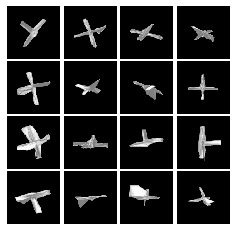

[Epoch 139/500] [Batch 0/126] [D loss: 0.564171][G loss: 0.892058][Lap loss: 3.107017] D(x): 1.1784 D(G(z)): 0.0112/-0.1370
[Epoch 139/500] [Batch 50/126] [D loss: 0.523810][G loss: 0.966682][Lap loss: 2.962355] D(x): 0.6909 D(G(z)): -0.5351/-0.4206
[Epoch 139/500] [Batch 100/126] [D loss: 0.486450][G loss: 1.113872][Lap loss: 2.769838] D(x): 0.2127 D(G(z)): -1.4216/-0.6039
[Epoch 140/500] [Batch 0/126] [D loss: 0.694330][G loss: 0.913214][Lap loss: 2.780371] D(x): 0.2953 D(G(z)): -0.2424/-0.2401
[Epoch 140/500] [Batch 50/126] [D loss: 0.492749][G loss: 1.107344][Lap loss: 2.642498] D(x): 0.6579 D(G(z)): -0.7016/-0.6151
[Epoch 140/500] [Batch 100/126] [D loss: 0.505933][G loss: 0.958821][Lap loss: 2.974692] D(x): 0.9563 D(G(z)): -0.4006/-0.3934
[Epoch 141/500] [Batch 0/126] [D loss: 0.374021][G loss: 1.367235][Lap loss: 3.105617] D(x): 0.8592 D(G(z)): -1.2974/-1.0087
[Epoch 141/500] [Batch 50/126] [D loss: 0.557903][G loss: 1.066147][Lap loss: 2.693297] D(x): 0.5147 D(G(z)): -0.6209/-0

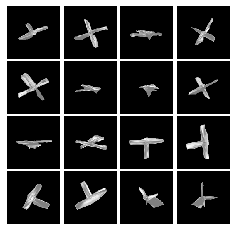

[Epoch 143/500] [Batch 0/126] [D loss: 0.555634][G loss: 1.276838][Lap loss: 2.838662] D(x): 0.2790 D(G(z)): -0.9998/-0.8388
[Epoch 143/500] [Batch 50/126] [D loss: 0.465089][G loss: 1.373115][Lap loss: 2.769854] D(x): 0.7201 D(G(z)): -0.8928/-0.9789
[Epoch 143/500] [Batch 100/126] [D loss: 0.544651][G loss: 1.094506][Lap loss: 2.984137] D(x): 0.4626 D(G(z)): -0.5669/-0.6217
[Epoch 144/500] [Batch 0/126] [D loss: 0.697859][G loss: 1.112522][Lap loss: 3.053815] D(x): -0.0644 D(G(z)): -0.5585/-0.6117
[Epoch 144/500] [Batch 50/126] [D loss: 0.412688][G loss: 1.472421][Lap loss: 2.989220] D(x): 1.0666 D(G(z)): -0.9698/-1.1188
[Epoch 144/500] [Batch 100/126] [D loss: 0.491004][G loss: 1.490501][Lap loss: 2.928864] D(x): 0.2626 D(G(z)): -1.2118/-1.1552
[Epoch 145/500] [Batch 0/126] [D loss: 0.484775][G loss: 1.360973][Lap loss: 2.626975] D(x): 0.8713 D(G(z)): -0.7195/-0.9186
[Epoch 145/500] [Batch 50/126] [D loss: 0.581782][G loss: 1.099543][Lap loss: 2.693576] D(x): 0.2263 D(G(z)): -0.7572/

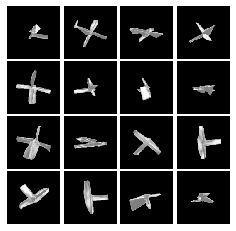

[Epoch 147/500] [Batch 0/126] [D loss: 0.630362][G loss: 1.021168][Lap loss: 2.664267] D(x): 0.1761 D(G(z)): -0.5473/-0.4374
[Epoch 147/500] [Batch 50/126] [D loss: 0.609862][G loss: 1.054016][Lap loss: 2.822687] D(x): 0.4621 D(G(z)): -0.4438/-0.5456
[Epoch 147/500] [Batch 100/126] [D loss: 0.692531][G loss: 0.911096][Lap loss: 2.988963] D(x): 0.3793 D(G(z)): -0.1149/-0.2035
[Epoch 148/500] [Batch 0/126] [D loss: 0.463546][G loss: 1.244379][Lap loss: 2.932053] D(x): 1.3020 D(G(z)): -0.4275/-0.7984
[Epoch 148/500] [Batch 50/126] [D loss: 0.490939][G loss: 1.198320][Lap loss: 2.967830] D(x): 0.6222 D(G(z)): -0.8449/-0.7237
[Epoch 148/500] [Batch 100/126] [D loss: 0.595146][G loss: 1.321103][Lap loss: 3.094987] D(x): 0.5011 D(G(z)): -0.4986/-0.9141
[Epoch 149/500] [Batch 0/126] [D loss: 0.509393][G loss: 1.235080][Lap loss: 2.935822] D(x): 0.7101 D(G(z)): -0.8693/-0.7735
[Epoch 149/500] [Batch 50/126] [D loss: 0.514219][G loss: 0.754767][Lap loss: 3.022619] D(x): 0.9940 D(G(z)): -0.2861/0

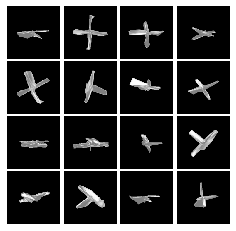

[Epoch 151/500] [Batch 0/126] [D loss: 0.634140][G loss: 0.871832][Lap loss: 2.889393] D(x): 0.3740 D(G(z)): -0.3285/-0.1548
[Epoch 151/500] [Batch 50/126] [D loss: 0.424753][G loss: 0.992438][Lap loss: 3.102712] D(x): 1.6557 D(G(z)): -0.5122/-0.4000
[Epoch 151/500] [Batch 100/126] [D loss: 0.383351][G loss: 1.046800][Lap loss: 3.238584] D(x): 1.4697 D(G(z)): -0.7825/-0.5082
[Epoch 152/500] [Batch 0/126] [D loss: 0.512078][G loss: 1.106978][Lap loss: 3.087383] D(x): 1.1305 D(G(z)): -0.2290/-0.5788
[Epoch 152/500] [Batch 50/126] [D loss: 0.591794][G loss: 1.290857][Lap loss: 2.906621] D(x): 0.6653 D(G(z)): -0.3389/-0.8803
[Epoch 152/500] [Batch 100/126] [D loss: 0.440067][G loss: 1.058881][Lap loss: 3.228869] D(x): 0.7620 D(G(z)): -1.0103/-0.4853
[Epoch 153/500] [Batch 0/126] [D loss: 0.517065][G loss: 1.751064][Lap loss: 2.913493] D(x): 0.3365 D(G(z)): -1.0454/-1.5045
[Epoch 153/500] [Batch 50/126] [D loss: 0.409238][G loss: 1.310769][Lap loss: 3.032775] D(x): 0.7045 D(G(z)): -1.1995/-

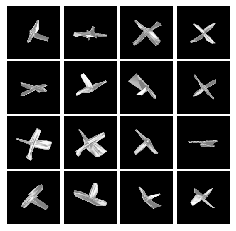

[Epoch 154/500] [Batch 100/126] [D loss: 0.596902][G loss: 1.324767][Lap loss: 3.023512] D(x): 0.3291 D(G(z)): -0.6732/-0.8639
[Epoch 155/500] [Batch 0/126] [D loss: 0.409975][G loss: 1.001460][Lap loss: 2.989815] D(x): 1.0638 D(G(z)): -0.8473/-0.4387
[Epoch 155/500] [Batch 50/126] [D loss: 0.444010][G loss: 1.346495][Lap loss: 3.587134] D(x): 0.9503 D(G(z)): -0.9030/-0.9400
[Epoch 155/500] [Batch 100/126] [D loss: 0.495317][G loss: 1.109884][Lap loss: 3.700995] D(x): 0.5450 D(G(z)): -0.9355/-0.5408
[Epoch 156/500] [Batch 0/126] [D loss: 0.473593][G loss: 1.075020][Lap loss: 3.444300] D(x): 1.2507 D(G(z)): -0.3920/-0.5095
[Epoch 156/500] [Batch 50/126] [D loss: 0.536696][G loss: 1.128330][Lap loss: 4.074792] D(x): 0.6899 D(G(z)): -0.4619/-0.6208
[Epoch 156/500] [Batch 100/126] [D loss: 0.498693][G loss: 1.225771][Lap loss: 3.389026] D(x): 0.5736 D(G(z)): -0.8199/-0.7953
[Epoch 157/500] [Batch 0/126] [D loss: 0.422873][G loss: 1.291418][Lap loss: 3.407105] D(x): 1.0322 D(G(z)): -0.8359/

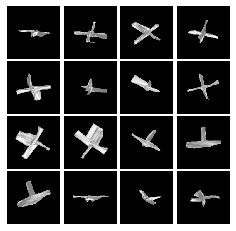

[Epoch 158/500] [Batch 100/126] [D loss: 0.506283][G loss: 1.040330][Lap loss: 3.064637] D(x): 0.9802 D(G(z)): -0.4424/-0.5328
[Epoch 159/500] [Batch 0/126] [D loss: 0.479162][G loss: 1.345514][Lap loss: 3.493537] D(x): 0.5502 D(G(z)): -1.1555/-0.9465
[Epoch 159/500] [Batch 50/126] [D loss: 0.627491][G loss: 1.005245][Lap loss: 3.052843] D(x): 0.3315 D(G(z)): -0.3478/-0.4577
[Epoch 159/500] [Batch 100/126] [D loss: 0.470041][G loss: 1.146673][Lap loss: 3.110041] D(x): 1.2785 D(G(z)): -0.3831/-0.6626
[Epoch 160/500] [Batch 0/126] [D loss: 0.339174][G loss: 1.541397][Lap loss: 3.335768] D(x): 1.3979 D(G(z)): -1.0386/-1.2517
[Epoch 160/500] [Batch 50/126] [D loss: 0.589734][G loss: 1.038831][Lap loss: 3.351507] D(x): 1.4375 D(G(z)): 0.2319/-0.5112
[Epoch 160/500] [Batch 100/126] [D loss: 0.509478][G loss: 1.439025][Lap loss: 3.296842] D(x): 0.3196 D(G(z)): -0.9933/-1.1315
[Epoch 161/500] [Batch 0/126] [D loss: 0.636736][G loss: 0.844974][Lap loss: 3.357489] D(x): 0.8585 D(G(z)): -0.0091/-

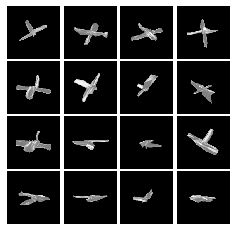

[Epoch 162/500] [Batch 100/126] [D loss: 0.516708][G loss: 0.771954][Lap loss: 3.116750] D(x): 1.2225 D(G(z)): -0.2769/-0.0091
[Epoch 163/500] [Batch 0/126] [D loss: 0.360933][G loss: 2.115675][Lap loss: 3.225345] D(x): 0.6364 D(G(z)): -1.8129/-1.9388
[Epoch 163/500] [Batch 50/126] [D loss: 0.472088][G loss: 1.198200][Lap loss: 3.203642] D(x): 1.1236 D(G(z)): -0.3624/-0.7613
[Epoch 163/500] [Batch 100/126] [D loss: 0.532019][G loss: 0.853367][Lap loss: 3.139781] D(x): 0.9313 D(G(z)): -0.3234/-0.2184
[Epoch 164/500] [Batch 0/126] [D loss: 0.503061][G loss: 1.301447][Lap loss: 2.970961] D(x): 0.7077 D(G(z)): -0.6815/-0.8905
[Epoch 164/500] [Batch 50/126] [D loss: 0.623618][G loss: 1.339634][Lap loss: 2.944860] D(x): 0.3340 D(G(z)): -0.3423/-0.9274
[Epoch 164/500] [Batch 100/126] [D loss: 0.432516][G loss: 0.929730][Lap loss: 3.492270] D(x): 1.1971 D(G(z)): -0.6214/-0.3238
[Epoch 165/500] [Batch 0/126] [D loss: 0.435442][G loss: 0.819225][Lap loss: 3.103712] D(x): 0.9145 D(G(z)): -0.7158/

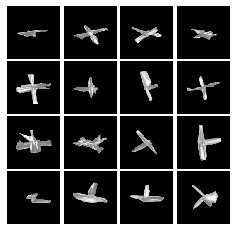

[Epoch 166/500] [Batch 100/126] [D loss: 0.624143][G loss: 0.704767][Lap loss: 3.784320] D(x): 0.9240 D(G(z)): -0.0635/0.1162
[Epoch 167/500] [Batch 0/126] [D loss: 0.571917][G loss: 1.408101][Lap loss: 3.397064] D(x): 0.3063 D(G(z)): -0.8443/-1.0203
[Epoch 167/500] [Batch 50/126] [D loss: 0.516169][G loss: 1.619433][Lap loss: 3.294888] D(x): 0.3410 D(G(z)): -1.0767/-1.3515
[Epoch 167/500] [Batch 100/126] [D loss: 0.626697][G loss: 0.628181][Lap loss: 3.127105] D(x): 0.7145 D(G(z)): -0.2917/0.3014
[Epoch 168/500] [Batch 0/126] [D loss: 0.408187][G loss: 1.455819][Lap loss: 3.245594] D(x): 0.7292 D(G(z)): -1.4419/-1.1344
[Epoch 168/500] [Batch 50/126] [D loss: 0.413989][G loss: 1.271448][Lap loss: 3.122668] D(x): 1.2997 D(G(z)): -0.8457/-0.8626
[Epoch 168/500] [Batch 100/126] [D loss: 0.450602][G loss: 1.636698][Lap loss: 3.339933] D(x): 0.8193 D(G(z)): -0.9575/-1.3615
[Epoch 169/500] [Batch 0/126] [D loss: 0.566629][G loss: 1.271502][Lap loss: 3.324531] D(x): 0.6739 D(G(z)): -0.4247/-0

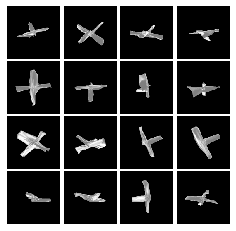

[Epoch 170/500] [Batch 100/126] [D loss: 0.627718][G loss: 1.644172][Lap loss: 2.942297] D(x): 0.1546 D(G(z)): -0.6244/-1.3131
[Epoch 171/500] [Batch 0/126] [D loss: 0.398684][G loss: 1.039837][Lap loss: 3.458752] D(x): 1.3946 D(G(z)): -0.6248/-0.4778
[Epoch 171/500] [Batch 50/126] [D loss: 0.342457][G loss: 1.800512][Lap loss: 2.879841] D(x): 0.8082 D(G(z)): -1.7118/-1.5569
[Epoch 171/500] [Batch 100/126] [D loss: 0.556522][G loss: 1.252739][Lap loss: 3.325239] D(x): 0.3090 D(G(z)): -0.6132/-0.7883
[Epoch 172/500] [Batch 0/126] [D loss: 0.716406][G loss: 0.993317][Lap loss: 3.171685] D(x): 0.4954 D(G(z)): 0.1089/-0.4302
[Epoch 172/500] [Batch 50/126] [D loss: 0.367538][G loss: 1.235078][Lap loss: 3.299294] D(x): 1.1336 D(G(z)): -0.9296/-0.8341
[Epoch 172/500] [Batch 100/126] [D loss: 0.713349][G loss: 0.803633][Lap loss: 3.279867] D(x): 0.1416 D(G(z)): -0.2755/-0.0718
[Epoch 173/500] [Batch 0/126] [D loss: 0.620670][G loss: 1.145017][Lap loss: 3.043604] D(x): 0.2715 D(G(z)): -0.4603/-

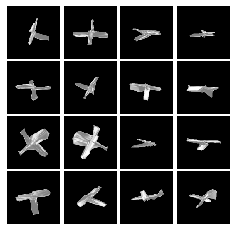

[Epoch 174/500] [Batch 100/126] [D loss: 0.345409][G loss: 1.035819][Lap loss: 3.180702] D(x): 1.5384 D(G(z)): -1.0045/-0.5018
[Epoch 175/500] [Batch 0/126] [D loss: 0.348057][G loss: 0.988466][Lap loss: 2.995329] D(x): 1.7571 D(G(z)): -0.7914/-0.4338
[Epoch 175/500] [Batch 50/126] [D loss: 0.331918][G loss: 0.889111][Lap loss: 3.021016] D(x): 1.8884 D(G(z)): -0.6851/-0.2414
[Epoch 175/500] [Batch 100/126] [D loss: 0.365185][G loss: 1.222804][Lap loss: 3.065411] D(x): 1.7343 D(G(z)): -0.6620/-0.7707
[Epoch 176/500] [Batch 0/126] [D loss: 0.470914][G loss: 0.799061][Lap loss: 3.029574] D(x): 1.2438 D(G(z)): -0.4768/-0.0771
[Epoch 176/500] [Batch 50/126] [D loss: 0.430202][G loss: 1.493533][Lap loss: 2.945335] D(x): 0.6934 D(G(z)): -1.0183/-1.1546
[Epoch 176/500] [Batch 100/126] [D loss: 0.510141][G loss: 1.244285][Lap loss: 3.093655] D(x): 0.5355 D(G(z)): -0.6748/-0.8126
[Epoch 177/500] [Batch 0/126] [D loss: 0.731877][G loss: 0.878970][Lap loss: 2.905951] D(x): 0.0450 D(G(z)): -0.1785/

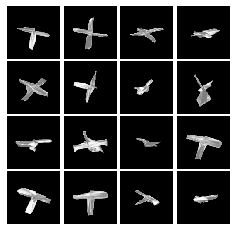

[Epoch 178/500] [Batch 100/126] [D loss: 0.485186][G loss: 0.921334][Lap loss: 3.363232] D(x): 1.4553 D(G(z)): -0.3774/-0.2416
[Epoch 179/500] [Batch 0/126] [D loss: 0.465737][G loss: 1.030780][Lap loss: 3.337296] D(x): 1.0163 D(G(z)): -0.3842/-0.4570
[Epoch 179/500] [Batch 50/126] [D loss: 0.412791][G loss: 1.375969][Lap loss: 3.181051] D(x): 0.7513 D(G(z)): -1.2132/-0.9865
[Epoch 179/500] [Batch 100/126] [D loss: 0.471691][G loss: 1.677124][Lap loss: 2.981635] D(x): 0.4097 D(G(z)): -1.2218/-1.4127
[Epoch 180/500] [Batch 0/126] [D loss: 0.489396][G loss: 0.882315][Lap loss: 3.153946] D(x): 1.7128 D(G(z)): -0.1257/-0.2596
[Epoch 180/500] [Batch 50/126] [D loss: 0.353043][G loss: 1.276338][Lap loss: 2.923644] D(x): 1.4723 D(G(z)): -0.9913/-0.8776
[Epoch 180/500] [Batch 100/126] [D loss: 0.585965][G loss: 0.901621][Lap loss: 3.093955] D(x): 0.2642 D(G(z)): -0.6980/-0.2346
[Epoch 181/500] [Batch 0/126] [D loss: 0.504797][G loss: 1.290206][Lap loss: 3.083831] D(x): 1.1550 D(G(z)): -0.3422/

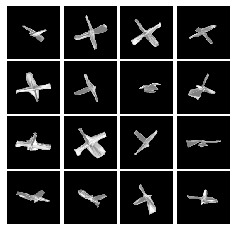

[Epoch 182/500] [Batch 100/126] [D loss: 0.507400][G loss: 1.152103][Lap loss: 3.183836] D(x): 0.4553 D(G(z)): -1.0410/-0.6593
[Epoch 183/500] [Batch 0/126] [D loss: 0.459386][G loss: 0.932341][Lap loss: 3.105339] D(x): 0.8253 D(G(z)): -0.7299/-0.3119
[Epoch 183/500] [Batch 50/126] [D loss: 0.635791][G loss: 1.291668][Lap loss: 3.028998] D(x): -0.0955 D(G(z)): -0.9200/-0.9147
[Epoch 183/500] [Batch 100/126] [D loss: 0.452816][G loss: 1.338172][Lap loss: 2.932035] D(x): 0.5937 D(G(z)): -1.1014/-0.9454
[Epoch 184/500] [Batch 0/126] [D loss: 0.371424][G loss: 1.221712][Lap loss: 3.014276] D(x): 1.5572 D(G(z)): -0.7663/-0.7511
[Epoch 184/500] [Batch 50/126] [D loss: 0.328997][G loss: 2.029510][Lap loss: 2.893091] D(x): 1.1636 D(G(z)): -1.4459/-1.7823
[Epoch 184/500] [Batch 100/126] [D loss: 0.446716][G loss: 1.362825][Lap loss: 2.808752] D(x): 0.9388 D(G(z)): -0.7223/-0.9721
[Epoch 185/500] [Batch 0/126] [D loss: 0.897306][G loss: 0.845613][Lap loss: 3.077905] D(x): -0.2927 D(G(z)): -0.126

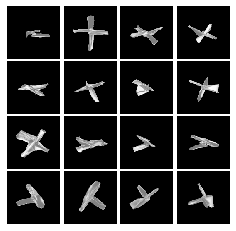

[Epoch 186/500] [Batch 100/126] [D loss: 0.510442][G loss: 1.219878][Lap loss: 3.135113] D(x): 0.6257 D(G(z)): -0.5807/-0.7736
[Epoch 187/500] [Batch 0/126] [D loss: 0.437546][G loss: 1.006682][Lap loss: 3.200257] D(x): 1.6322 D(G(z)): -0.2156/-0.4733
[Epoch 187/500] [Batch 50/126] [D loss: 0.604398][G loss: 1.109051][Lap loss: 3.129356] D(x): 0.4098 D(G(z)): -0.4832/-0.6040
[Epoch 187/500] [Batch 100/126] [D loss: 0.724764][G loss: 0.918741][Lap loss: 3.190285] D(x): 0.9096 D(G(z)): 0.3268/-0.3030
[Epoch 188/500] [Batch 0/126] [D loss: 0.520518][G loss: 1.505911][Lap loss: 3.220611] D(x): 0.5612 D(G(z)): -0.9774/-1.1923
[Epoch 188/500] [Batch 50/126] [D loss: 0.543430][G loss: 0.960184][Lap loss: 3.287493] D(x): 0.5615 D(G(z)): -0.6258/-0.3169
[Epoch 188/500] [Batch 100/126] [D loss: 0.440908][G loss: 1.264836][Lap loss: 3.095459] D(x): 1.2781 D(G(z)): -0.6059/-0.8246
[Epoch 189/500] [Batch 0/126] [D loss: 0.437479][G loss: 1.471770][Lap loss: 3.273421] D(x): 0.7983 D(G(z)): -1.0114/-

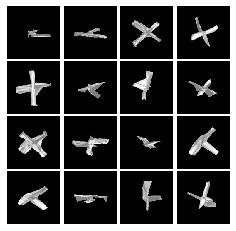

[Epoch 190/500] [Batch 100/126] [D loss: 0.349185][G loss: 1.977822][Lap loss: 3.084914] D(x): 0.9673 D(G(z)): -1.4286/-1.7783
[Epoch 191/500] [Batch 0/126] [D loss: 0.508510][G loss: 1.052999][Lap loss: 3.246008] D(x): 0.8352 D(G(z)): -0.6595/-0.4507
[Epoch 191/500] [Batch 50/126] [D loss: 0.451665][G loss: 1.123825][Lap loss: 3.070144] D(x): 1.1488 D(G(z)): -0.6256/-0.6282
[Epoch 191/500] [Batch 100/126] [D loss: 0.547126][G loss: 1.162542][Lap loss: 2.893460] D(x): 0.5519 D(G(z)): -0.6139/-0.6775
[Epoch 192/500] [Batch 0/126] [D loss: 0.373628][G loss: 1.559502][Lap loss: 2.926469] D(x): 0.9942 D(G(z)): -1.2547/-1.2678
[Epoch 192/500] [Batch 50/126] [D loss: 0.523927][G loss: 0.686832][Lap loss: 2.911508] D(x): 1.2587 D(G(z)): -0.2425/0.1331
[Epoch 192/500] [Batch 100/126] [D loss: 0.348916][G loss: 1.512685][Lap loss: 2.821018] D(x): 0.9257 D(G(z)): -1.1784/-1.2319
[Epoch 193/500] [Batch 0/126] [D loss: 0.475363][G loss: 1.305542][Lap loss: 2.859042] D(x): 0.5923 D(G(z)): -1.1209/-

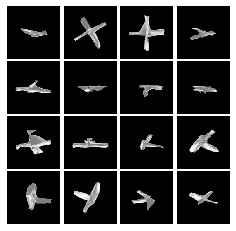

[Epoch 194/500] [Batch 100/126] [D loss: 0.470751][G loss: 1.537479][Lap loss: 2.920822] D(x): 0.5759 D(G(z)): -0.8733/-1.2282
[Epoch 195/500] [Batch 0/126] [D loss: 0.405158][G loss: 1.741662][Lap loss: 2.808768] D(x): 0.7399 D(G(z)): -1.2714/-1.4559
[Epoch 195/500] [Batch 50/126] [D loss: 0.461774][G loss: 1.082000][Lap loss: 3.263257] D(x): 0.7444 D(G(z)): -0.8844/-0.5812
[Epoch 195/500] [Batch 100/126] [D loss: 0.553223][G loss: 1.159990][Lap loss: 3.550046] D(x): 0.7313 D(G(z)): -0.3787/-0.6946
[Epoch 196/500] [Batch 0/126] [D loss: 0.581291][G loss: 1.462529][Lap loss: 3.079709] D(x): 0.3455 D(G(z)): -0.6543/-1.1397
[Epoch 196/500] [Batch 50/126] [D loss: 0.621977][G loss: 0.860859][Lap loss: 3.102423] D(x): 0.3497 D(G(z)): -0.3090/-0.1941
[Epoch 196/500] [Batch 100/126] [D loss: 0.462865][G loss: 1.083289][Lap loss: 3.015222] D(x): 1.6305 D(G(z)): -0.4104/-0.5329
[Epoch 197/500] [Batch 0/126] [D loss: 0.433532][G loss: 1.221233][Lap loss: 2.994772] D(x): 0.9839 D(G(z)): -0.9038/

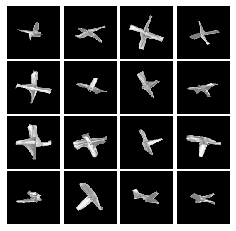

[Epoch 198/500] [Batch 100/126] [D loss: 0.431258][G loss: 0.768419][Lap loss: 3.165400] D(x): 1.2327 D(G(z)): -0.6789/-0.0097
[Epoch 199/500] [Batch 0/126] [D loss: 0.570016][G loss: 1.303299][Lap loss: 3.067834] D(x): 0.5405 D(G(z)): -0.5037/-0.8837
[Epoch 199/500] [Batch 50/126] [D loss: 0.541600][G loss: 1.194432][Lap loss: 3.373121] D(x): 0.3890 D(G(z)): -1.0074/-0.6899
[Epoch 199/500] [Batch 100/126] [D loss: 0.433490][G loss: 1.920447][Lap loss: 3.037014] D(x): 0.6914 D(G(z)): -1.0260/-1.7261
[Epoch 200/500] [Batch 0/126] [D loss: 0.502271][G loss: 1.348816][Lap loss: 3.166506] D(x): 0.5665 D(G(z)): -0.7942/-0.9659
[Epoch 200/500] [Batch 50/126] [D loss: 0.362557][G loss: 1.445369][Lap loss: 3.292735] D(x): 1.6562 D(G(z)): -0.7405/-1.0785
[Epoch 200/500] [Batch 100/126] [D loss: 0.512666][G loss: 1.224761][Lap loss: 3.098997] D(x): 1.1057 D(G(z)): -0.4853/-0.7610
[Epoch 201/500] [Batch 0/126] [D loss: 0.517397][G loss: 0.891390][Lap loss: 3.154599] D(x): 0.8426 D(G(z)): -0.2479/

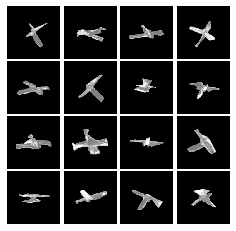

[Epoch 202/500] [Batch 50/126] [D loss: 0.615596][G loss: 1.293549][Lap loss: 3.232143] D(x): 0.5186 D(G(z)): -0.6899/-0.8297
[Epoch 202/500] [Batch 100/126] [D loss: 0.403080][G loss: 1.706827][Lap loss: 3.144095] D(x): 0.6461 D(G(z)): -1.4123/-1.4428
[Epoch 203/500] [Batch 0/126] [D loss: 0.458644][G loss: 1.170797][Lap loss: 2.841202] D(x): 1.0851 D(G(z)): -0.4718/-0.7048
[Epoch 203/500] [Batch 50/126] [D loss: 0.483007][G loss: 1.499537][Lap loss: 3.192353] D(x): 1.0488 D(G(z)): -0.4665/-1.1803
[Epoch 203/500] [Batch 100/126] [D loss: 0.407407][G loss: 1.086763][Lap loss: 3.377604] D(x): 1.4853 D(G(z)): -0.6734/-0.5703
[Epoch 204/500] [Batch 0/126] [D loss: 0.658290][G loss: 0.886079][Lap loss: 3.590834] D(x): 1.0271 D(G(z)): 0.2446/-0.2787
[Epoch 204/500] [Batch 50/126] [D loss: 0.565532][G loss: 1.163638][Lap loss: 3.524196] D(x): 0.7891 D(G(z)): -0.3843/-0.6786
[Epoch 204/500] [Batch 100/126] [D loss: 0.340397][G loss: 1.518767][Lap loss: 3.397920] D(x): 1.1080 D(G(z)): -1.3596/

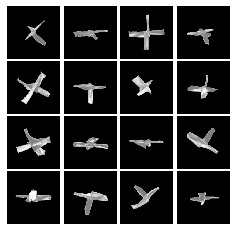

[Epoch 206/500] [Batch 50/126] [D loss: 0.528040][G loss: 0.832068][Lap loss: 3.516605] D(x): 0.5401 D(G(z)): -0.7435/-0.1202
[Epoch 206/500] [Batch 100/126] [D loss: 0.632789][G loss: 0.732176][Lap loss: 2.978626] D(x): 0.5997 D(G(z)): -0.1433/0.0243
[Epoch 207/500] [Batch 0/126] [D loss: 0.478259][G loss: 1.560965][Lap loss: 3.334032] D(x): 0.5922 D(G(z)): -0.8868/-1.2321
[Epoch 207/500] [Batch 50/126] [D loss: 0.476603][G loss: 0.758656][Lap loss: 3.318748] D(x): 0.2726 D(G(z)): -1.1930/0.0225
[Epoch 207/500] [Batch 100/126] [D loss: 0.634575][G loss: 0.950927][Lap loss: 3.256487] D(x): 0.4928 D(G(z)): -0.1634/-0.3400
[Epoch 208/500] [Batch 0/126] [D loss: 0.515231][G loss: 1.285096][Lap loss: 3.231151] D(x): 0.4620 D(G(z)): -0.6678/-0.8707
[Epoch 208/500] [Batch 50/126] [D loss: 0.526743][G loss: 0.971404][Lap loss: 3.091013] D(x): 0.4956 D(G(z)): -0.5489/-0.4042
[Epoch 208/500] [Batch 100/126] [D loss: 0.426583][G loss: 1.683022][Lap loss: 3.046083] D(x): 1.6331 D(G(z)): -0.3407/-

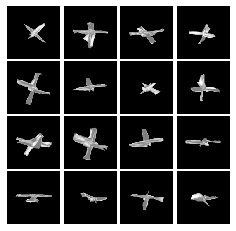

[Epoch 210/500] [Batch 50/126] [D loss: 0.392992][G loss: 1.156414][Lap loss: 3.329405] D(x): 1.2472 D(G(z)): -0.8754/-0.6747
[Epoch 210/500] [Batch 100/126] [D loss: 0.494770][G loss: 0.990533][Lap loss: 3.800069] D(x): 0.6521 D(G(z)): -0.8719/-0.4067
[Epoch 211/500] [Batch 0/126] [D loss: 0.513519][G loss: 1.403249][Lap loss: 3.584534] D(x): 0.4036 D(G(z)): -0.9243/-1.0289
[Epoch 211/500] [Batch 50/126] [D loss: 0.417204][G loss: 1.474693][Lap loss: 3.293859] D(x): 1.0860 D(G(z)): -1.0028/-1.0826
[Epoch 211/500] [Batch 100/126] [D loss: 0.647758][G loss: 0.859591][Lap loss: 3.254437] D(x): 0.7311 D(G(z)): -0.1404/-0.1959
[Epoch 212/500] [Batch 0/126] [D loss: 0.455446][G loss: 1.551840][Lap loss: 3.260645] D(x): 0.7475 D(G(z)): -1.0449/-1.2357
[Epoch 212/500] [Batch 50/126] [D loss: 0.480139][G loss: 1.240712][Lap loss: 3.538441] D(x): 1.3898 D(G(z)): -0.3680/-0.7408
[Epoch 212/500] [Batch 100/126] [D loss: 0.489228][G loss: 1.146037][Lap loss: 3.427885] D(x): 0.7154 D(G(z)): -0.8160

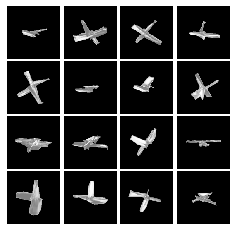

[Epoch 214/500] [Batch 50/126] [D loss: 0.415188][G loss: 1.041607][Lap loss: 3.703146] D(x): 1.5360 D(G(z)): -0.4842/-0.4375


In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
Lap_losses = []
iters = 0

adversarial_loss = nn.BCEWithLogitsLoss()

from soft_renderer import LaplacianLoss

laplacian_loss = LaplacianLoss(netG.mesh_generator.sphere_vs.cpu(), netG.sphere_fs[0].cpu(), average=True).cuda()

if os.path.exists(checkpoint_file):
    if resume:
        checkpoint = torch.load(checkpoint_file)
        netD.load_state_dict(checkpoint['netD'])
        netG.load_state_dict(checkpoint['netG'])
        optimizer_D.load_state_dict(checkpoint['optimizer_D'])
        optimizer_G.load_state_dict(checkpoint['optimizer_G'])

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    #last_g_error = 1.0
    for i, data in enumerate(dataloader, 0):
        
        batch = data[0]
        batch_size_i = batch.shape[0]
        # Adversarial ground truths
        valid = torch.FloatTensor(batch_size_i, 1).fill_(real_label).cuda()
        fake = torch.FloatTensor(batch_size_i, 1).fill_(fake_label).cuda()
        # Configure input
        # noise = torch.Tensor(*batch.shape).normal_(0.0, 0.05).cuda()
        real_imgs = batch.cuda() - 0.5 #+ noise

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.Tensor(batch_size_i, nz).normal_(0,1).cuda()

        # Generate a batch of images
        gen_imgs, gen_verts = netG(z)
        gen_imgs -= 0.5 #normalize
        
        # Loss measures generator's ability to fool the discriminator
        #g_loss = ls_generator_loss(netD(gen_imgs))
        fake_logits_g = netD(gen_imgs)
        g_adv_loss = adversarial_loss(fake_logits_g, valid)
        
        lap_loss = laplacian_loss(gen_verts)
        
        g_loss = g_adv_loss + lap_loss

        g_loss.backward()
        optimizer_G.step()
        G_losses.append(g_adv_loss.item())

        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_logits = netD(real_imgs)
        fake_logits_d = netD(gen_imgs.detach())
        real_loss = adversarial_loss(real_logits, valid)
        fake_loss = adversarial_loss(fake_logits_d, fake)
        #d_loss = ls_discriminator_loss(netD(real_imgs), netD(gen_imgs.detach()))
        d_loss = (real_loss + fake_loss) / 2 #* (torch.abs(fake_logits_d.mean()) + torch.abs(real_logits.mean()) + torch.abs(fake_logits_g.detach().mean()))/3
        
        d_loss.backward()
#         if d_loss.item() > 0.05:
        
 
        optimizer_D.step()
        
        
        D_losses.append(d_loss.item())
        
        #Lap_losses.append(lap_loss.item())

        if i % 50 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f][G loss: %f][Lap loss: %f] D(x): %.4f D(G(z)): %.4f/%.4f"
                % (epoch, num_epochs, i, len(dataloader), d_loss.item(), g_adv_loss.item(),
                lap_loss.item(), real_logits.mean().item(), fake_logits_d.mean().item(),
                fake_logits_g.mean().item())
            )
            
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise)[0][:,:3].detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            imgs_numpy = fake.numpy()
            show_images(imgs_numpy[0:16])
            plt.show()
        
        iters += 1
    
    torch.save({
        'netD': netD.state_dict(),
        'netG': netG.state_dict(),
        'optimizer_D': optimizer_D.state_dict(),
        'optimizer_G': optimizer_G.state_dict(),
    }, checkpoint_file)

       
 #         ############################
#         # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
#         ###########################
#         ## Train with all-real batch
#         netD.zero_grad()
#         # Format batch
#         real_cpu = data[0].cuda()
#         b_size = real_cpu.size(0)
#         label = torch.full((b_size,), real_label).cuda()
#         # Forward pass real batch through D
#         real_logits = netD(real_cpu).view(-1)
#         # Calculate loss on all-real batch
#         #errD_real = criterion(output, label)
#         # Calculate gradients for D in backward pass
#         #errD_real.backward()
#         D_x = real_logits.mean().item()

        
#          ## Train with all-fake batch
#         # Generate batch of latent vectors
#         noise = torch.randn(batch_size, nz).cuda()
#         # Generate fake image batch with G
#         fake, generated_vertices = netG(noise)
        
#         label.fill_(fake_label)
#         # Classify all fake batch with D
#         fake_logits = netD(fake.detach()).view(-1)
#         # Calculate D's loss on the all-fake batch
#         #errD_fake = criterion(output, label)
#         #logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
#         d_total_error = ls_discriminator_loss(real_logits, fake_logits)

#         D_G_z1 = fake_logits.mean().item()
#         # Add the gradients from the all-real and all-fake batches
#         #errD = errD_real + errD_fake
#         # Update D
#         # Calculate the gradients for this batch
#         d_total_error.backward()
#         optimizerD.step()

        
#         ############################
#         # (2) Update G network: maximize log(D(G(z)))
#         ###########################
#         netG.zero_grad()
#         label.fill_(real_label)  # fake labels are real for generator cost
#         # Since we just updated D, perform another forward pass of all-fake batch through D
#         g_logits = netD(fake).view(-1)
#         # Calculate G's loss based on this output
#         #errG = criterion(output, label)
#         # Calculate gradients for G
#         g_total_error = ls_generator_loss(g_logits)
#         g_total_error.backward()
#         D_G_z2 = g_logits.mean().item()
#         # Update G
#         optimizerG.step()
#         #last_g_error = g_total_error

#         # Output training stats
#         if i % 50 == 0:
#             print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
#                   % (epoch, num_epochs, i, len(dataloader),
#                      d_total_error.item(), g_total_error.item(), D_x, D_G_z1, D_G_z2))

#         # Save Losses for plotting later
#         G_losses.append(d_total_error.item())
#         D_losses.append(g_total_error.item())

#         # Check how the generator is doing by saving G's output on fixed_noise
#         if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
#             with torch.no_grad():
#                 fake = netG(fixed_noise)[0][:,:3].detach().cpu()
#             img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

#        iters += 1

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(60,60))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:batch_size, :3], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()